### Import functions, define parameters and load data

In [78]:
from utils_pcmci import *
from utilities import *
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import itertools
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, MultiHeadAttention, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import SGD, Adam # For some reason Adam is running slow on M1, M2 so using legacy version

def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training, mask=None):
        attn_output = self.mha(x, x, x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Dense(d_model)
        self.pos_encoding = get_positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

class TimeSeriesTransformer:
    def __init__(self, input_shape, num_layers=2, d_model=64, num_heads=4, dff=128, rate=0.1, 
                 batch_size=32, epochs=1000, lr=0.01, patience=10, optimizer='adam', loss='mse'):
        self.input_shape = input_shape
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.patience = patience
        self.optimizer = Adam(learning_rate=lr) if optimizer == 'adam' else SGD(learning_rate=lr)
        self.loss = loss
        self.model = self._build_model()

    def _build_model(self):
        inputs = Input(shape=self.input_shape)
        encoder = TransformerEncoder(num_layers=self.num_layers, d_model=self.d_model, num_heads=self.num_heads,
                                     dff=self.dff, maximum_position_encoding=self.input_shape[0], rate=self.rate)
        x = encoder(inputs, training=True)
        x = tf.keras.layers.Flatten()(x)
        outputs = Dense(1)(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=self.optimizer, loss=self.loss)
        return model

    def train(self, X_train, y_train, X_val=None, y_val=None, early_stopping=True, verbosity=1):
        if early_stopping:
            early_stop = EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)
            validation_data = (X_val, y_val) if X_val is not None and y_val is not None else None
            history = self.model.fit(X_train, y_train, batch_size=self.batch_size, epochs=self.epochs, 
                                     validation_data=validation_data, callbacks=[early_stop], verbose = verbosity)
            return history
        else:
            validation_data = (X_val, y_val) if X_val is not None and y_val is not None else None
            history = self.model.fit(X_train, y_train, batch_size=self.batch_size, epochs=self.epochs, validation_data=validation_data)
            return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def predict(self, X):
        return self.model.predict(X)

def create_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X[i:(i + sequence_length)])
        ys.append(y[i + sequence_length])
    return np.array(Xs), np.array(ys)

def model_grid_search(X, y, param_grid, n_splits, sequence_length=12, early_stopping=True):
    num_features = X.shape[1]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_params = None
    best_val_loss = float('inf')
    best_history = None

    for params in itertools.product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        print(f"Evaluating parameters: {param_dict}")
        val_scores = []

        for fold, (train_index, val_index) in enumerate(tscv.split(X)):
            X_train, y_train = X[train_index], y[train_index]
            X_val, y_val = X[val_index], y[val_index]

            X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
            X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)

            input_shape = (sequence_length, num_features)
            ts_model = TimeSeriesTransformer(input_shape, 
                                             num_layers=param_dict['num_layers'], 
                                             d_model=param_dict['d_model'], 
                                             num_heads=param_dict['num_heads'], 
                                             dff=param_dict['dff'], 
                                             rate=param_dict['dropout'], 
                                             batch_size=param_dict['batch_size'], 
                                             epochs=param_dict['epochs'], 
                                             lr=param_dict['lr'], 
                                             patience=param_dict['patience'], 
                                             optimizer=param_dict['optimizer'], 
                                             loss=param_dict['loss'])

            history = ts_model.train(X_train_seq, y_train_seq, X_val_seq, y_val_seq, early_stopping, verbosity=0)
            val_loss = ts_model.evaluate(X_val_seq, y_val_seq)
            val_scores.append(val_loss)

        print(f'Mean validation loss: {np.mean(val_scores)}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = param_dict
            best_history = history
        
        print(f"Best parameters so far: {best_params} \\ Best validation loss so far: {best_val_loss}")

    print(f"Best parameters: {best_params}")
    print(f"Best validation loss: {best_val_loss}")
    return best_params, best_val_loss, best_history

def train_final_model(X, y, X_test, y_test, best_params, sequence_length=12, n_splits=5, train_on_fulldata=True, plot_loss=True, early_stopping=True):
    num_features = X.shape[1]
    tscv = TimeSeriesSplit(n_splits=n_splits)

    if train_on_fulldata:
        X_final_train_seq, y_final_train_seq = create_sequences(X, y, sequence_length)
        X_final_test_seq, y_final_test_seq = create_sequences(X_test, y_test, sequence_length)

        input_shape = (sequence_length, num_features)
        ts_model_final_adjusted = TimeSeriesTransformer(input_shape, 
                                                        num_layers=best_params['num_layers'], 
                                                        d_model=best_params['d_model'], 
                                                        num_heads=best_params['num_heads'], 
                                                        dff=best_params['dff'], 
                                                        rate=best_params['dropout'], 
                                                        batch_size=best_params['batch_size'], 
                                                        epochs=best_params['epochs'], 
                                                        lr=best_params['lr'], 
                                                        patience=best_params['patience'], 
                                                        optimizer=best_params['optimizer'], 
                                                        loss=best_params['loss'])

        history_final_adjusted = ts_model_final_adjusted.train(X_final_train_seq, y_final_train_seq, early_stopping)

        test_loss_adjusted = ts_model_final_adjusted.evaluate(X_final_test_seq, y_final_test_seq)
        print(f'Adjusted Test Loss: {test_loss_adjusted}')

        if plot_loss:
            plt.plot(history_final_adjusted.history['loss'], label='train')
            if 'val_loss' in history_final_adjusted.history:
                plt.plot(history_final_adjusted.history['val_loss'], label='val')
            plt.title('Training Loss per Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

        return ts_model_final_adjusted, history_final_adjusted, test_loss_adjusted

    if not train_on_fulldata:
        val_scores = []
        for fold, (train_index, val_index) in enumerate(tscv.split(X)):
            X_train, y_train = X[train_index], y[train_index]
            X_val, y_val = X[val_index], y[val_index]

            X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
            X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)

            input_shape = (sequence_length, num_features)
            ts_model = TimeSeriesTransformer(input_shape, 
                                             num_layers=best_params['num_layers'], 
                                             d_model=best_params['d_model'], 
                                             num_heads=best_params['num_heads'], 
                                             dff=best_params['dff'], 
                                             rate=best_params['dropout'], 
                                             batch_size=best_params['batch_size'], 
                                             epochs=best_params['epochs'], 
                                             lr=best_params['lr'], 
                                             patience=best_params['patience'], 
                                             optimizer=best_params['optimizer'], 
                                             loss=best_params['loss'])

            history = ts_model.train(X_train_seq, y_train_seq, X_val_seq, y_val_seq, early_stopping)

            val_loss = ts_model.evaluate(X_val_seq, y_val_seq)
            val_scores.append(val_loss)
            print(f'Validation loss for fold {fold+1}: {val_loss}')

        print(f'Mean validation loss: {np.mean(val_scores)}')

        if plot_loss:
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='val')
            plt.title('Training and Validation Loss per Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

        return ts_model, history, val_scores
    
def load_and_prepare_data(data_config: str, comp: int, scale='standard', split_date='2016-11-30', MA = False, verbose=True):
    d, fulldata, _ = load_varimax_data(variables, seasons_mask, model_name, n_comps, mask)

    start_end_date = d[next(iter(d.keys()))]['results']['start_end']
    end_date = pd.to_datetime(start_end_date[1])
    daterange = pd.date_range(start_end_date[0], end_date + pd.DateOffset(months=1), freq='M')

    fulldata_pd = pd.DataFrame(fulldata, columns=[f'c{i}' for i in range(1, fulldata.shape[1]+1)], index=daterange)
    lagged_features = create_lagged_features(fulldata_pd, 5)

    combined_df = pd.concat([fulldata_pd, lagged_features], axis=1).dropna()

    if MA:
        combined_df[matching_comp_MA] = combined_df[matching_comp_MA].rolling(window=3).mean()
        combined_df = combined_df.dropna()

    # combined_df = combined_df.reset_index(drop=True)
    # Define the train and test data based on a specific desired date for the split
    daterange = combined_df.index

    train_size = daterange.get_loc(split_date) # int(len(fulldata_pd) * 0.90)
    train_df = combined_df.iloc[:train_size]
    test_df = combined_df.iloc[train_size:]

    if data_config == 'combined':
        X = train_df.drop(columns=[f'c{comp+1}']).values
        X_test = test_df.drop(columns=[f'c{comp+1}']).values

    elif data_config == 'selected_lasso':
        X = train_df[selected_variables_lasso[comp]['selected_features_names']].values
        X_test = test_df[selected_variables_lasso[comp]['selected_features_names']].values

    elif data_config == 'selected_pcmci':
        X = train_df[selected_variables[comp]['selected_features_names']].values
        X_test = test_df[selected_variables[comp]['selected_features_names']].values
    
    # adding a new variable selection with PCMCI and autoregressive features up to lag 4
    elif data_config == 'selected_pcmci_+autoreg':
        X = train_df[selected_variables[comp]['selected_features_names'] + [f'c{comp+1}_lag_{i}' for i in range(1, 5)]].values
        X_test = test_df[selected_variables[comp]['selected_features_names'] + [f'c{comp+1}_lag_{i}' for i in range(1, 5)]].values

    elif data_config == 'only_components':        
        train_df = train_df.drop(columns=train_df.filter(like='lag').columns)
        test_df = test_df.drop(columns=test_df.filter(like='lag').columns)

        X = train_df.drop(columns=[f'c{comp+1}']).values
        X_test = test_df.drop(columns=[f'c{comp+1}']).values

    else:
        raise ValueError("Invalid data configuration")

    idx = 7 if MA else 5
    y =  train_df[f'c{comp+1}'].values.reshape(-1, 1)
    y_test = test_df[f'c{comp+1}'].values.reshape(-1, 1)
    y2 = fulldata_pd[f'c{comp+1}'][:train_size].values.reshape(-1, 1)
    y_test2 = fulldata_pd[f'c{comp+1}'][(train_size+idx):].values.reshape(-1, 1)

    if verbose:
        print("Fulldata shape = %s" % str(fulldata.shape))
        print("X shape = %s" % str(X.shape), "y shape = %s" % str(y.shape))
        print("X test shape = %s" % str(X_test.shape), "y test shape = %s" % str(y_test.shape))

    if scale == 'standard':
        scaler_X = StandardScaler()
        X = scaler_X.fit_transform(X)
        X_test = scaler_X.transform(X_test)

        scaler_y = StandardScaler()
        y = scaler_y.fit_transform(y)
        y_test = scaler_y.transform(y_test)

        scaler_y = StandardScaler()
        y2 = scaler_y.fit_transform(y2)
        y_test2 = scaler_y.transform(y_test2)

    elif scale == 'minmax':
        scaler_X = MinMaxScaler()
        X = scaler_X.fit_transform(X)
        X_test = scaler_X.transform(X_test)

        scaler_y = MinMaxScaler()
        y = scaler_y.fit_transform(y)
        y_test = scaler_y.transform(y_test)

        scaler_y = MinMaxScaler()
        y2 = scaler_y.fit_transform(y2)
        y_test2 = scaler_y.transform(y_test2)

    elif scale == None:
        scaler_X = None
        scaler_y = None
        pass
    else:
        raise ValueError("Invalid scaling method")

    return X, y, X_test, y_test, {'y2': y2, 'y_test2': y_test2, 'scaler_X': scaler_X, 'scaler_y': scaler_y, 'time': daterange}

In [79]:
import pickle 
import warnings
warnings.filterwarnings("ignore")

# seasons_mask = {'DJF': [12, 1, 2], 'MAM': [3, 4, 5], 'JJA': [6, 7, 8], 'SON': [9, 10, 11]}
seasons_mask = {'FMA': [2, 3, 4], 'MJJ': [5, 6, 7], 'ASO': [8, 9, 10], 'NDJ': [11, 12, 1]} # descarted 
              
variables = [
    'sst', 
    # 'mtpr', 
    'prate',
    # 'msl'
    ]

model_name = {
    'sst': 'FULL_ERA5_SST_1940-2024_converted_detrend.nc',
    # 'mtpr': 'ERA5_mean_precipitation_1940-2024_converted_detrend.nc',
    'prate': 'PRATE_NCEP_NCAR_Reanalysis_1948-2024.nc',
    # 'msl': 'ERA5_mean_SLP_1940-2024_converted_detrend.nc'
    }

target = 'prate_FMA'
ip = 0
n_comps = {'sst': 15, 'prate': 5}
n_splits = 5
mask = 'unmasked'
method_arg = 'pcmci'
sequence_length = 12
period_length = 38 * 2
model = "_".join(variables)
months = "_".join(seasons_mask.keys())

# Define the number of components and the names of the components
total_comps = int((sum(n_comps.values()) / len(n_comps)) * len(seasons_mask) * len(model_name))

selected_components=['c'+str(i) for i in range(1,total_comps+1)] #  + 2 to include the component that is the precipitation rate
comp_names = [f'{var}_{months}' for months in seasons_mask.keys() for var in variables for _ in range(n_comps[var])]
comps_order_file = pd.DataFrame({'comp_number': ['c'+str(i) for i in range(1, total_comps+1)], # + 2 to include the component that is the precipitation rate
                                 'comps': [i for i in range(total_comps)], # + 1 to include the component that is the precipitation rate
                                 'name': [ i + '_' + j for i, j in zip(selected_components, comp_names)]})

# Find the 'comps' value for the first occurrence of the desired components to calculate the MA
temp = pd.DataFrame(comps_order_file)
matching_comp_MA = temp[temp['name'].str.contains(target, case=False)]['comp_number'].tolist()

# Upload variable selection results
file_name = './runs/pcmci_results/test/variable_selection_pcmci_%s_3dm_comps-%s_months-%s_%s_%s_%s_unmasked.bin' % (model, str(list(n_comps.values())), 
                                                                                                                     months, method_arg, period_length, ip) 
file_name_lasso = './runs/pcmci_results/variable_selection_LASSO_%s_3dm_%s-comps-%s_months-%s_%s.bin' % (model, total_comps, str(list(n_comps.values())), months, mask)
selected_variables = pickle.load(open(file_name, 'rb')) # For PCMCI use the unmasked data 
selected_variables_lasso = pickle.load(open(file_name_lasso, 'rb')) # for LASSO use the unmasked data 

In [80]:
COMP_START = int(matching_comp_MA[0].split('c')[1]) - 1
COMP_END = int(matching_comp_MA[-1].split('c')[1])

# checking if shapes are correct
X, y, X_test, y_test, extra_dict = load_and_prepare_data('combined', COMP_START, 'standard', MA=True)
# print(y_test[0], y_test[-1])
print()
X, y, X_test, y_test, extra_dict = load_and_prepare_data('selected_pcmci', COMP_START, 'standard', MA=True)
# print(y_test[0], y_test[-1])
print()
X, y, X_test, y_test, extra_dict = load_and_prepare_data('selected_pcmci_+autoreg', COMP_START, 'standard', MA=True)
# print(y_test[0], y_test[-1])
print()
X, y, X_test, y_test, extra_dict = load_and_prepare_data('selected_lasso', COMP_START, 'standard', MA=True)
# print(y_test[0], y_test[-1])
print()

# pd.DataFrame({'time': extra_dict['time'], 'y': np.vstack([y, y_test]).reshape(-1)}).to_excel('./check_dates.xlsx')

Fulldata shape = (912, 80)
X shape = (819, 479) y shape = (819, 1)
X test shape = (86, 479) y test shape = (86, 1)

Fulldata shape = (912, 80)
X shape = (819, 22) y shape = (819, 1)
X test shape = (86, 22) y test shape = (86, 1)

Fulldata shape = (912, 80)
X shape = (819, 26) y shape = (819, 1)
X test shape = (86, 26) y test shape = (86, 1)

Fulldata shape = (912, 80)
X shape = (819, 89) y shape = (819, 1)
X test shape = (86, 89) y test shape = (86, 1)



#### Grid Search

In [5]:
if False:
    grid_search_dict = {}
    MA = True
    COMP_START = int(matching_comp_MA[0].split('c')[1]) - 1
    COMP_END = int(matching_comp_MA[-1].split('c')[1])

    param_grid = {
        'num_layers': [2, 3], #1, 2, 3
        'd_model': [16, 32, 64, 128],
        'num_heads': [2, 4],
        'dff': [128, 256, 512],
        'dropout': [0.1, 0.3],
        'batch_size': [64],
        'epochs': [100],  # Smaller number for testing
        'lr': [0.0001, 0.001],
        'patience': [25],
        'optimizer': ['adam'],
        'loss': ['mse']
    }

    for i, comp in enumerate(range(COMP_START, COMP_END)):
        print(f"Training model {comp}")
        print('-'*50)

        try:
            X, y, X_test, y_test, extra_dict = load_and_prepare_data('selected_pcmci_+autoreg', comp, 'standard', MA=MA)
            
            best_params, best_val_loss, best_history = model_grid_search(X, y, param_grid, n_splits=2, sequence_length=12)
        
            grid_search_dict[comp] = {'best_params': best_params, 'best_val_loss': best_val_loss} #, 'best_history': best_history}

        except Exception as e:
            print("An error occurred:", e)

Training model 10
--------------------------------------------------
Fulldata shape = (912, 60)
X shape = (819, 27) y shape = (819, 1)
X test shape = (86, 27) y test shape = (86, 1)
Evaluating parameters: {'num_layers': 2, 'd_model': 16, 'num_heads': 2, 'dff': 128, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.0001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}
9/9 [==============================] - 0s 1ms/step - loss: 1.6040
Mean validation loss: 1.9532551169395447
Best parameters so far: {'num_layers': 2, 'd_model': 16, 'num_heads': 2, 'dff': 128, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.0001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'} \ Best validation loss so far: 1.6040319204330444
Evaluating parameters: {'num_layers': 2, 'd_model': 16, 'num_heads': 2, 'dff': 128, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}
9/9 [==============================] - 0s 1ms/step - loss: 0.615

In [235]:
if False:
    # grid_search_dict = {'num_layers': 2, 'd_model': 32, 'num_heads': 2, 'dff': 256, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.0001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}
    # {'num_layers': 2, 'd_model': 64, 'num_heads': 2, 'dff': 512, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.0001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}
    # {'num_layers': 2, 'd_model': 32, 'num_heads': 2, 'dff': 256, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.0001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'} \ Best validation loss so far: 0.41342416405677795

    file_name = f'./runs/param_grid_search_{model}_total-comps-{total_comps}_comp-{list(n_comps.values())}_MA-{MA}_selected_pcmci_+autoreg.bin'
    file = open(file_name, 'wb')
    pickle.dump(grid_search_dict, file, protocol=-1)
    file.close()

In [10]:
if False: 
     grid_search_dict = {
     10: {'best_params': {'num_layers': 1, 'd_model': 64, 'num_heads': 4, 'dff': 256, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}, 
          'best_val_loss': 0.47331738471984863},

     11: {'best_params': {'num_layers': 2, 'd_model': 16, 'num_heads': 4, 'dff': 128, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}, 
          'best_val_loss': 0.18165358901023865},

     12: {'best_params': {'num_layers': 2, 'd_model': 128, 'num_heads': 4, 'dff': 256, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.0001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}, 
          'best_val_loss': 0.47253164649009705},

     13: {'best_params': {'num_layers': 2, 'd_model': 16, 'num_heads': 2, 'dff': 128, 'dropout': 0.3, 'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}, 
          'best_val_loss': 0.43484750390052795},

     14: {'best_params': {'num_layers': 3, 'd_model': 64, 'num_heads': 2, 'dff': 256, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}, 
          'best_val_loss': 0.666283369064331}
     }

     # For PRATE - 3, SST - 10. FMA, MJJ, ASO, NDJ seasons. Unmasked PCMCI selection.

     grid_search_dict = {
     10: {'best_params': {'num_layers': 3, 'd_model': 128, 'num_heads': 4, 'dff': 512, 'dropout': 0.3, 'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}, 
          'best_val_loss': 0.17824715375900269},

     11: {'best_params': {'num_layers': 2, 'd_model': 16, 'num_heads': 4, 'dff': 128, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}, 
          'best_val_loss': 0.18165358901023865},

     12: {'best_params': {'num_layers': 2, 'd_model': 128, 'num_heads': 4, 'dff': 256, 'dropout': 0.1, 'batch_size': 64, 'epochs': 100, 'lr': 0.0001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}, 
          'best_val_loss': 0.47253164649009705},
     }

#### Run Models

In [ ]:
if False:
    MA = True
    file_name = f'./runs/param_grid_search_{model}_total-comps-{total_comps}_comp-{list(n_comps.values())}_MA-{MA}_selected_pcmci_+autoreg.bin'
    custom_params = pickle.load(open(file_name, 'rb'))

In [82]:
temp_params = {'num_layers': 3, 'd_model': 128, 'num_heads': 4, 'dff': 512, 'dropout': 0.3, 'batch_size': 64, 'epochs': 100, 'lr': 0.001, 'patience': 25, 'optimizer': 'adam', 'loss': 'mse'}

COMP_START = int(matching_comp_MA[0].split('c')[1]) - 1
COMP_END = int(matching_comp_MA[-1].split('c')[1])
MA = True

# temp_params = {'num_layers': 2, 
#                'd_model': 32, 
#                'num_heads': 2, 
#                'dff': 256, 
#                'dropout': 0.1, 
#                'batch_size': 64, 
#                'epochs': 500, 
#                'lr': 0.0001, 
#                'patience': 25, 
#                'optimizer': 'adam', 
#                'loss': 'mse'}

import json 
param_file = f'./runs/encoder_results/encoder_param_{model}_comp-{str([COMP_START, COMP_END])}_total-{total_comps}_MA-{MA}_.json'
with open(param_file, 'w') as f:
    json.dump(temp_params, f)

In [83]:
# Traning for combined data
model_components_dict_combined = {}
data_config = 'combined'

for comp in range(COMP_START, COMP_END):
    X, y, X_test, y_test, extra_dict = load_and_prepare_data(data_config, comp, 'standard', MA=MA) # combined, only_components, selected_lasso, selected_pcmci

    ts_model, history, test_loss = train_final_model(X, y, X_test, y_test, temp_params, sequence_length, train_on_fulldata=False, plot_loss=False, early_stopping=True)
    
    model_components_dict_combined[comp] = {'model': ts_model, 
                                         'history': history, 
                                         'test_loss': test_loss,
                                         'X_test': X_test,
                                         'y_test': y_test,
                                         'y_test2': extra_dict['y_test2'],
                                         'scaler_y': extra_dict['scaler_y']}

    ts_model.model.save_weights(f'./runs/encoder_results/encoder_weights_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.h5')
    ts_model.model.save(f'./runs/encoder_results/encoder_model_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.h5')
    history_path = f'./runs/encoder_results/encoder_history_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.pkl'
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)
    print(f"Model {comp} saved")

Fulldata shape = (912, 80)
X shape = (819, 479) y shape = (819, 1)
X test shape = (86, 479) y test shape = (86, 1)
Epoch 1/100
2/2 [==============================] - 2s 298ms/step - loss: 13.8408 - val_loss: 2.3689
Epoch 2/100
2/2 [==============================] - 0s 72ms/step - loss: 7.0808 - val_loss: 3.9926
Epoch 3/100
2/2 [==============================] - 0s 65ms/step - loss: 2.4203 - val_loss: 3.1064
Epoch 4/100
2/2 [==============================] - 0s 68ms/step - loss: 3.8477 - val_loss: 2.2066
Epoch 5/100
2/2 [==============================] - 0s 68ms/step - loss: 1.4939 - val_loss: 1.7297
Epoch 6/100
2/2 [==============================] - 0s 68ms/step - loss: 0.8691 - val_loss: 2.5511
Epoch 7/100
2/2 [==============================] - 0s 69ms/step - loss: 1.5747 - val_loss: 1.6820
Epoch 8/100
2/2 [==============================] - 0s 68ms/step - loss: 1.1592 - val_loss: 1.1276
Epoch 9/100
2/2 [==============================] - 0s 69ms/step - loss: 0.7244 - val_loss: 1.8647
E

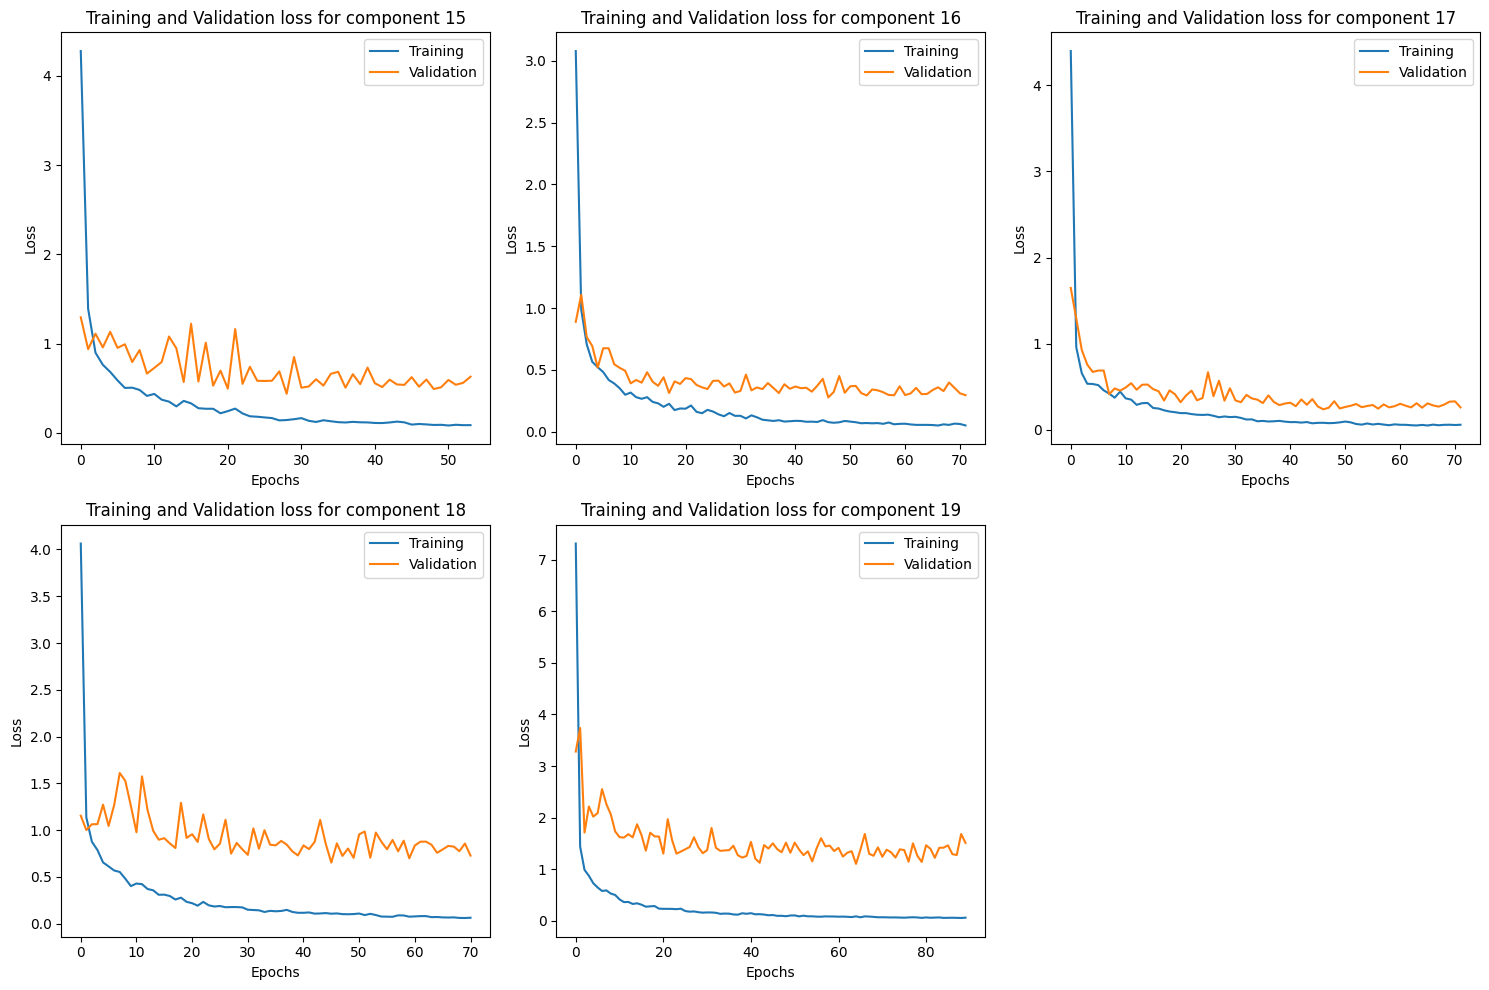

In [84]:
# Create 5 different plots for each component in the same figure
fig, ax = plt.subplots(figsize=(15, n_comps[target.split('_')[0]]*2), nrows=n_comps[target.split('_')[0]]//2, ncols=3)
ax = ax.flatten()

for i, comp in enumerate(range(COMP_START, COMP_END)):
    history = model_components_dict_combined[comp]['history']
    ax[i].plot(history.history['loss'], label = f'Training')
    ax[i].plot(history.history['val_loss'], label = f'Validation')

    ax[i].set_title(f'Training and Validation loss for component {comp}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].legend()

if len(model_components_dict_combined) < len(ax):
        fig.delaxes(ax[-1])

plt.tight_layout()
plt.show()

In [85]:
# Training for selected PCMCI data
model_components_dict_pcmci = {}
data_config = 'selected_pcmci'

for comp in range(COMP_START, COMP_END):
    X, y, X_test, y_test, extra_dict = load_and_prepare_data(data_config, comp, 'standard', MA=MA) # combined, only_components, selected_lasso, selected_pcmci
    # custom_params[comp]['best_params']
    ts_model, history, test_loss = train_final_model(X, y, X_test, y_test, temp_params, sequence_length = 12, train_on_fulldata=False, plot_loss=False, early_stopping=True)
    
    model_components_dict_pcmci[comp] = {'model': ts_model, 
                                         'history': history, 
                                         'test_loss': test_loss,
                                         'X_test': X_test,
                                         'y_test': y_test,
                                         'y_test2': extra_dict['y_test2'],
                                         'scaler_y': extra_dict['scaler_y']}

    ts_model.model.save_weights(f'./runs/encoder_results/encoder_weights_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.h5')
    ts_model.model.save(f'./runs/encoder_results/encoder_model_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.h5')
    history_path = f'./runs/encoder_results/encoder_history_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.pkl'
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)
    print(f"Model {comp} saved")

Fulldata shape = (912, 80)
X shape = (819, 22) y shape = (819, 1)
X test shape = (86, 22) y test shape = (86, 1)
Epoch 1/100
2/2 [==============================] - 1s 283ms/step - loss: 31.0012 - val_loss: 5.9494
Epoch 2/100
2/2 [==============================] - 0s 66ms/step - loss: 6.4603 - val_loss: 11.1919
Epoch 3/100
2/2 [==============================] - 0s 66ms/step - loss: 10.2420 - val_loss: 1.8973
Epoch 4/100
2/2 [==============================] - 0s 64ms/step - loss: 1.5325 - val_loss: 3.3850
Epoch 5/100
2/2 [==============================] - 0s 65ms/step - loss: 2.9321 - val_loss: 3.0532
Epoch 6/100
2/2 [==============================] - 0s 67ms/step - loss: 1.9034 - val_loss: 1.2622
Epoch 7/100
2/2 [==============================] - 0s 65ms/step - loss: 0.7741 - val_loss: 1.5093
Epoch 8/100
2/2 [==============================] - 0s 65ms/step - loss: 1.1492 - val_loss: 1.8616
Epoch 9/100
2/2 [==============================] - 0s 64ms/step - loss: 1.7410 - val_loss: 1.5374
E

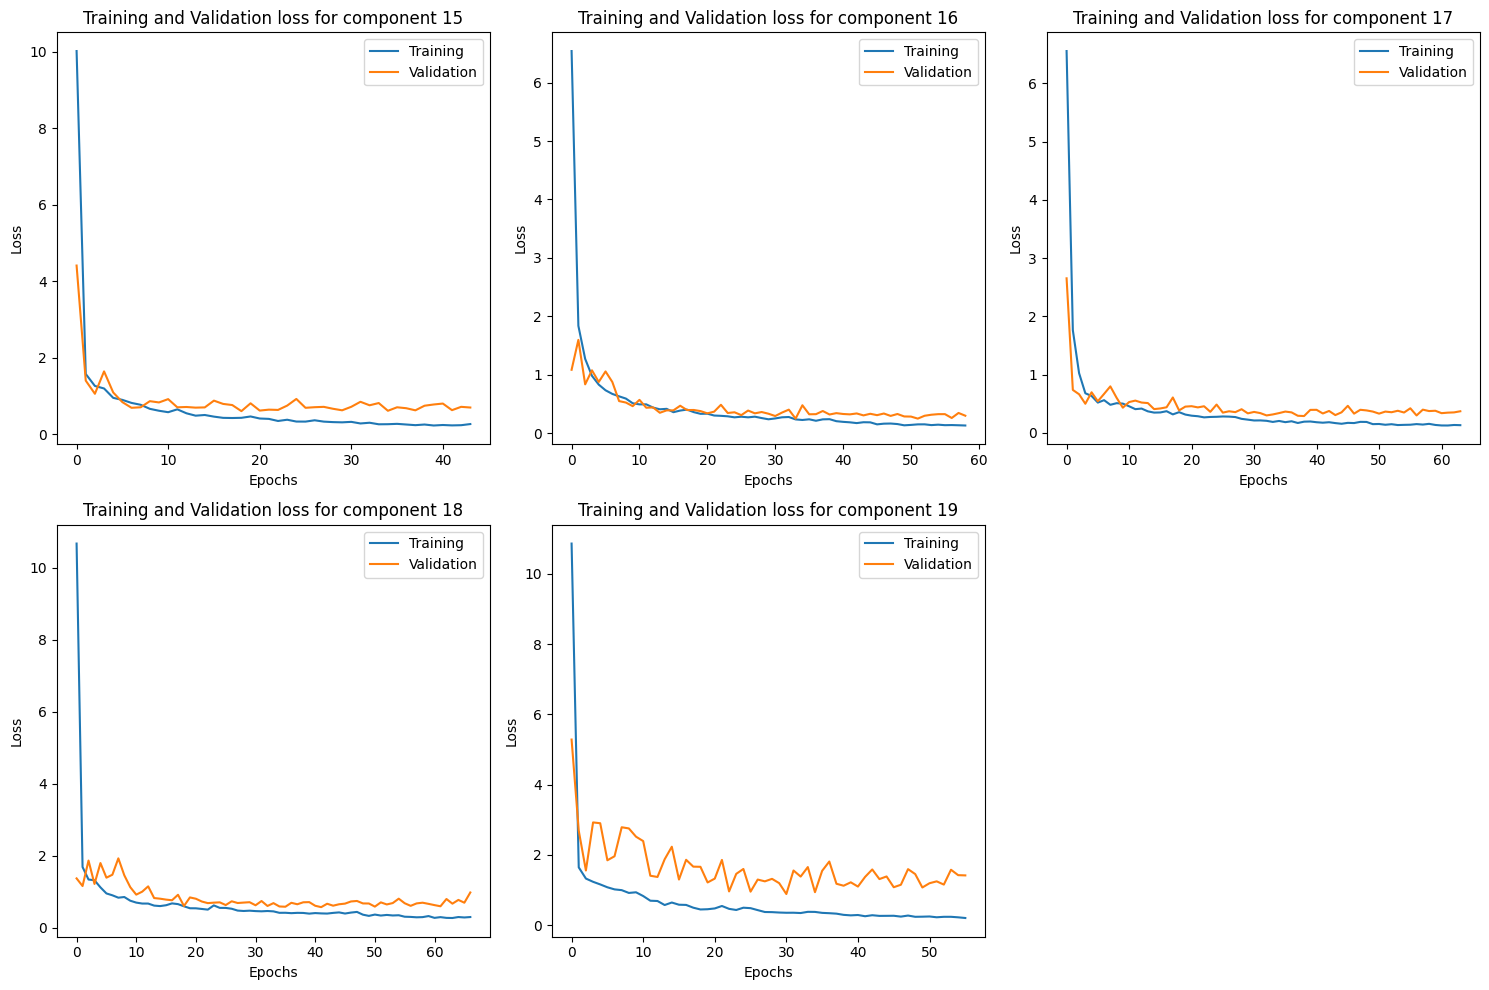

In [86]:
# Create 5 different plots for each component in the same figure
fig, ax = plt.subplots(figsize=(15, n_comps[target.split('_')[0]]*2), nrows=n_comps[target.split('_')[0]]//2, ncols=3)
ax = ax.flatten()

for i, comp in enumerate(range(COMP_START, COMP_END)):
    history = model_components_dict_pcmci[comp]['history']
    ax[i].plot(history.history['loss'], label = f'Training')
    ax[i].plot(history.history['val_loss'], label = f'Validation')

    ax[i].set_title(f'Training and Validation loss for component {comp}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].legend()

if len(model_components_dict_pcmci) < len(ax):
        fig.delaxes(ax[-1])

plt.tight_layout()
plt.show()

In [87]:
# Traning for PCMCI + autoregressive features
model_components_dict_pcmci_auto = {}
data_config = 'selected_pcmci_+autoreg'

for comp in range(COMP_START, COMP_END):
    X, y, X_test, y_test, extra_dict = load_and_prepare_data(data_config, comp, 'standard', MA=MA) # combined, only_components, selected_lasso, selected_pcmci
    # custom_params[comp]['best_params']
    ts_model, history, test_loss = train_final_model(X, y, X_test, y_test, temp_params, sequence_length = 12, train_on_fulldata=False, plot_loss=False, early_stopping=True)
    
    model_components_dict_pcmci_auto[comp] = {'model': ts_model, 
                                            'history': history, 
                                            'test_loss': test_loss,
                                            'X_test': X_test,
                                            'y_test': y_test,
                                            'y_test2': extra_dict['y_test2'],
                                            'scaler_y': extra_dict['scaler_y']}  

    ts_model.model.save_weights(f'./runs/encoder_results/encoder_weights_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.h5')
    ts_model.model.save(f'./runs/encoder_results/encoder_model_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.h5')
    history_path = f'./runs/encoder_results/encoder_history_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.pkl'

    with open(history_path, 'wb') as f:
        pickle.dump(history, f)

    print(f"Model {comp} saved")

Fulldata shape = (912, 80)
X shape = (819, 26) y shape = (819, 1)
X test shape = (86, 26) y test shape = (86, 1)
Epoch 1/100
2/2 [==============================] - 1s 270ms/step - loss: 14.7878 - val_loss: 6.1855
Epoch 2/100
2/2 [==============================] - 0s 71ms/step - loss: 7.8814 - val_loss: 1.8379
Epoch 3/100
2/2 [==============================] - 0s 66ms/step - loss: 1.7161 - val_loss: 3.1843
Epoch 4/100
2/2 [==============================] - 0s 65ms/step - loss: 2.8579 - val_loss: 1.9412
Epoch 5/100
2/2 [==============================] - 0s 67ms/step - loss: 1.1648 - val_loss: 1.3344
Epoch 6/100
2/2 [==============================] - 0s 66ms/step - loss: 1.3223 - val_loss: 2.2236
Epoch 7/100
2/2 [==============================] - 0s 67ms/step - loss: 1.5005 - val_loss: 1.2396
Epoch 8/100
2/2 [==============================] - 0s 66ms/step - loss: 0.8838 - val_loss: 1.0488
Epoch 9/100
2/2 [==============================] - 0s 63ms/step - loss: 0.9069 - val_loss: 1.3894
Epo

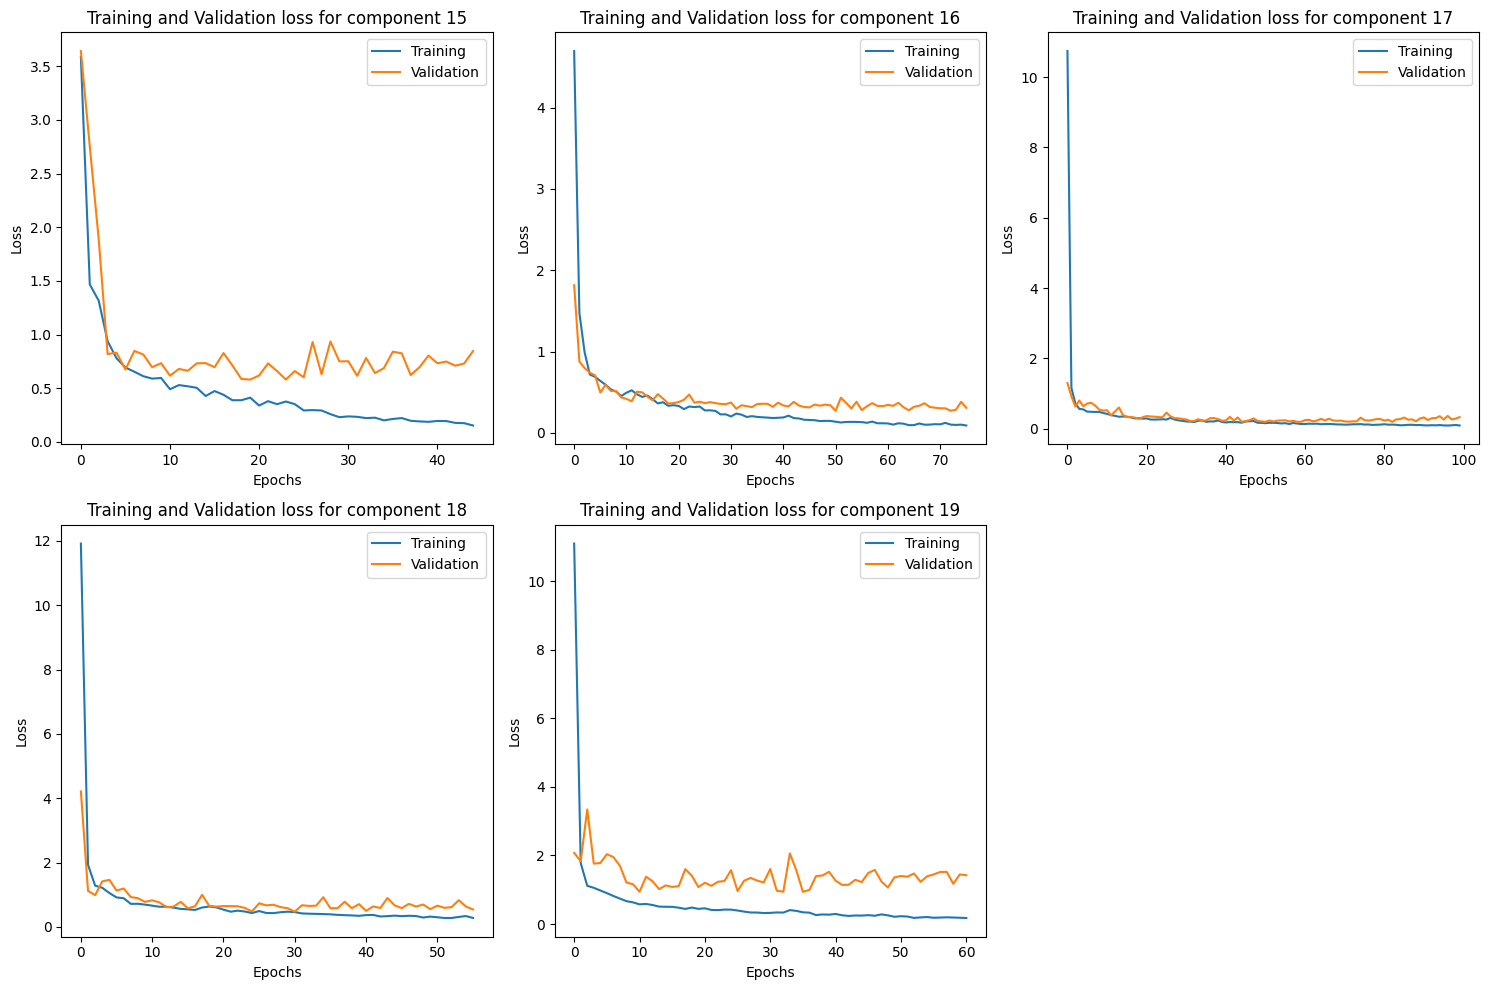

In [88]:
# Create 5 different plots for each component in the same figure
fig, ax = plt.subplots(figsize=(15, n_comps[target.split('_')[0]]*2), nrows=n_comps[target.split('_')[0]]//2, ncols=3)
ax = ax.flatten()

for i, comp in enumerate(range(COMP_START, COMP_END)):
    history = model_components_dict_pcmci_auto[comp]['history']
    ax[i].plot(history.history['loss'], label = f'Training')
    ax[i].plot(history.history['val_loss'], label = f'Validation')

    ax[i].set_title(f'Training and Validation loss for component {comp}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].legend()

if len(model_components_dict_pcmci_auto) < len(ax):
        fig.delaxes(ax[-1])

plt.tight_layout()
plt.show()

In [89]:
# Traning for LASSO
model_components_dict_lasso = {}
data_config = 'selected_lasso'

for comp in range(COMP_START, COMP_END):
    X, y, X_test, y_test, extra_dict = load_and_prepare_data(data_config, comp, 'standard', MA=MA) # combined, only_components, selected_lasso, selected_pcmci
    # custom_params[comp]['best_params']
    ts_model, history, test_loss = train_final_model(X, y, X_test, y_test, temp_params, sequence_length = 12, train_on_fulldata=False, plot_loss=False, early_stopping=True)
    
    model_components_dict_lasso[comp] = {'model': ts_model, 
                                         'history': history, 
                                         'test_loss': test_loss,
                                         'X_test': X_test,
                                         'y_test': y_test,
                                         'y_test2': extra_dict['y_test2'],
                                         'scaler_y': extra_dict['scaler_y']}    

    ts_model.model.save_weights(f'./runs/encoder_results/encoder_weights_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.h5')
    ts_model.model.save(f'./runs/encoder_results/encoder_model_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.h5')
    history_path = f'./runs/encoder_results/encoder_history_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{data_config}.pkl'

    with open(history_path, 'wb') as f:
        pickle.dump(history, f)

    print(f"Model {comp} saved")

Fulldata shape = (912, 80)
X shape = (819, 89) y shape = (819, 1)
X test shape = (86, 89) y test shape = (86, 1)
Epoch 1/100
2/2 [==============================] - 1s 273ms/step - loss: 13.8602 - val_loss: 3.6421
Epoch 2/100
2/2 [==============================] - 0s 64ms/step - loss: 6.4907 - val_loss: 4.3785
Epoch 3/100
2/2 [==============================] - 0s 69ms/step - loss: 2.9075 - val_loss: 2.9308
Epoch 4/100
2/2 [==============================] - 0s 66ms/step - loss: 3.0521 - val_loss: 2.2904
Epoch 5/100
2/2 [==============================] - 0s 68ms/step - loss: 1.7671 - val_loss: 1.5511
Epoch 6/100
2/2 [==============================] - 0s 62ms/step - loss: 1.4533 - val_loss: 2.5746
Epoch 7/100
2/2 [==============================] - 0s 67ms/step - loss: 2.0519 - val_loss: 1.4740
Epoch 8/100
2/2 [==============================] - 0s 65ms/step - loss: 0.8385 - val_loss: 1.3001
Epoch 9/100
2/2 [==============================] - 0s 65ms/step - loss: 0.9228 - val_loss: 1.9081
Epo

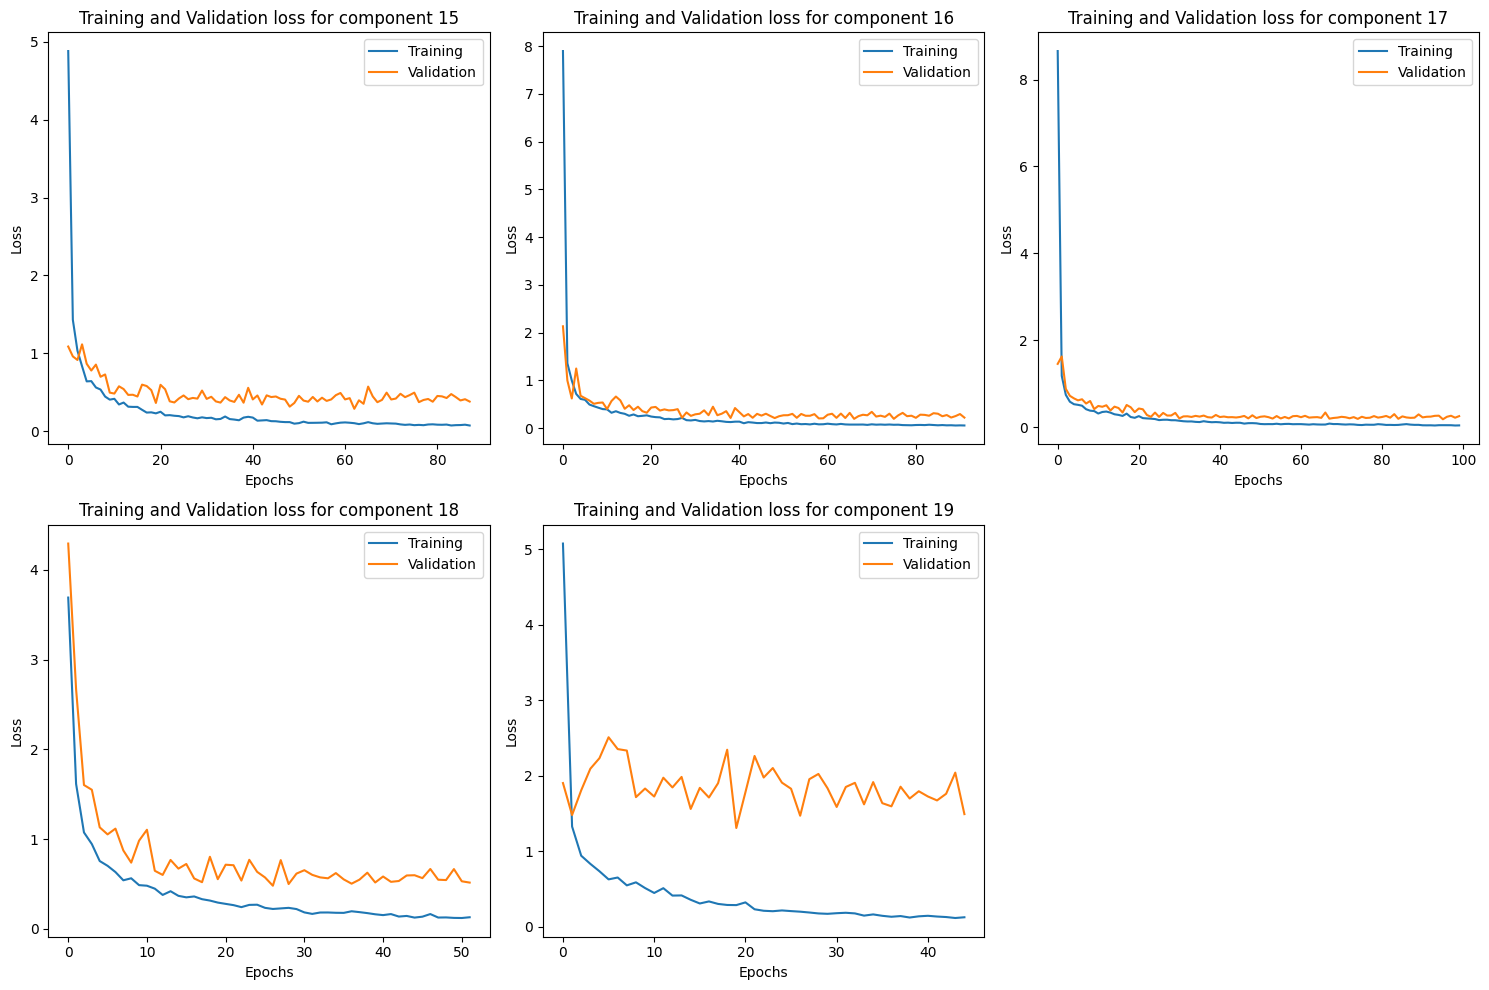

In [90]:
# Create 5 different plots for each component in the same figure
fig, ax = plt.subplots(figsize=(15, n_comps[target.split('_')[0]]*2), nrows=n_comps[target.split('_')[0]]//2, ncols=3)
ax = ax.flatten()

for i, comp in enumerate(range(COMP_START, COMP_END)):
    history = model_components_dict_lasso[comp]['history']
    ax[i].plot(history.history['loss'], label = f'Training')
    ax[i].plot(history.history['val_loss'], label = f'Validation')

    ax[i].set_title(f'Training and Validation loss for component {comp}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].legend()

if len(model_components_dict_lasso) < len(ax):
        fig.delaxes(ax[-1])

plt.tight_layout()
plt.show()

#### Final Model Training

In [91]:
# Traning for combined data
if False:
    temp_params['epochs'] = 150
    
    model_components_dict_combined, model_components_dict_pcmci, model_components_dict_pcmci_auto, model_components_dict_lasso = {}, {}, {}, {}
    model_dict = [model_components_dict_combined, model_components_dict_pcmci, model_components_dict_pcmci_auto, model_components_dict_lasso]
    data_config = ['combined', 'selected_pcmci', 'selected_pcmci_+autoreg', 'selected_lasso']

    for config, m_dict in zip(data_config, model_dict):
        for comp in range(COMP_START, COMP_END):
            X, y, X_test, y_test, extra_dict = load_and_prepare_data(config, comp, 'standard', MA=MA)

            ts_model, history, test_loss = train_final_model(X, y, X_test, y_test, temp_params, sequence_length=12, train_on_fulldata=True, plot_loss=False, early_stopping=False)
            
            m_dict[comp] = {'model': ts_model,
                            'history': history,
                            'test_loss': test_loss,
                            'X_test': X_test,
                            'y_test': y_test,
                            'y_test2': extra_dict['y_test2'],
                            'scaler_y': extra_dict['scaler_y']}

#### Predictions

In [92]:
## LOAD MODELS 
if False:
    from keras.models import load_model

    data_configs = ['combined', 'selected_pcmci', 'selected_pcmci_+autoreg', 'selected_lasso']

    def load_model_dict(data_configs):
        combined, pcmci, pcmci_auto, lasso = {}, {}, {}, {}

        for comp, config in itertools.product(range(COMP_START, COMP_END), data_configs):
            
            X, y, X_test, y_test, extra_dict = load_and_prepare_data(config, comp, 'standard', MA=MA, verbose=False)
            file_name = f'./runs/encoder_results/encoder_model_{model}_total-comps-{total_comps}_comp-{comp}_MA-{MA}_{config}.h5'
            
            loaded_model = load_model(file_name, custom_objects={'TransformerEncoder': TransformerEncoder})

            if config == 'combined':
                combined[comp] = {'model': loaded_model, 
                                'X_test': X_test,
                                'y_test': y_test,
                                'y_test2': extra_dict['y_test2'],
                                'scaler_y': extra_dict['scaler_y']}
                
            elif config == 'selected_pcmci':
                pcmci[comp] = {'model': loaded_model,
                            'X_test': X_test,
                            'y_test': y_test,
                            'y_test2': extra_dict['y_test2'],
                            'scaler_y': extra_dict['scaler_y']}
                
            elif config == 'selected_pcmci_+autoreg':
                pcmci_auto[comp] = {'model': loaded_model,
                                    'X_test': X_test,
                                    'y_test': y_test,
                                    'y_test2': extra_dict['y_test2'],
                                    'scaler_y': extra_dict['scaler_y']}
                
            elif config == 'selected_lasso':
                lasso[comp] = {'model': loaded_model,
                            'X_test': X_test,
                            'y_test': y_test,
                            'y_test2': extra_dict['y_test2'],
                            'scaler_y': extra_dict['scaler_y']}
        
        return combined, pcmci, pcmci_auto, lasso

    model_components_dict_combined, model_components_dict_pcmci, model_components_dict_pcmci_auto, model_components_dict_lasso = load_model_dict(data_configs)

RESULTS FOR COMBINED DATA
----------------------------------------------------------------------------------------------------

Results for 15:
(74, 12, 479) (74, 1)
3/3 [==============================] - 0s 7ms/step
Correlation for true component 15:  0.25886643836948264
R2 for component 15 -0.938533337538485
--------------------------------------------------
Results for 16:
(74, 12, 479) (74, 1)
3/3 [==============================] - 0s 10ms/step
Correlation for true component 16:  0.820230189944024
R2 for component 16 0.30627232542151495
--------------------------------------------------
Results for 17:
(74, 12, 479) (74, 1)
3/3 [==============================] - 0s 7ms/step
Correlation for true component 17:  0.39275070105663634
R2 for component 17 -1.1552728059777642
--------------------------------------------------
Results for 18:
(74, 12, 479) (74, 1)
3/3 [==============================] - 0s 7ms/step
Correlation for true component 18:  0.674210011984052
R2 for component 18 0.4

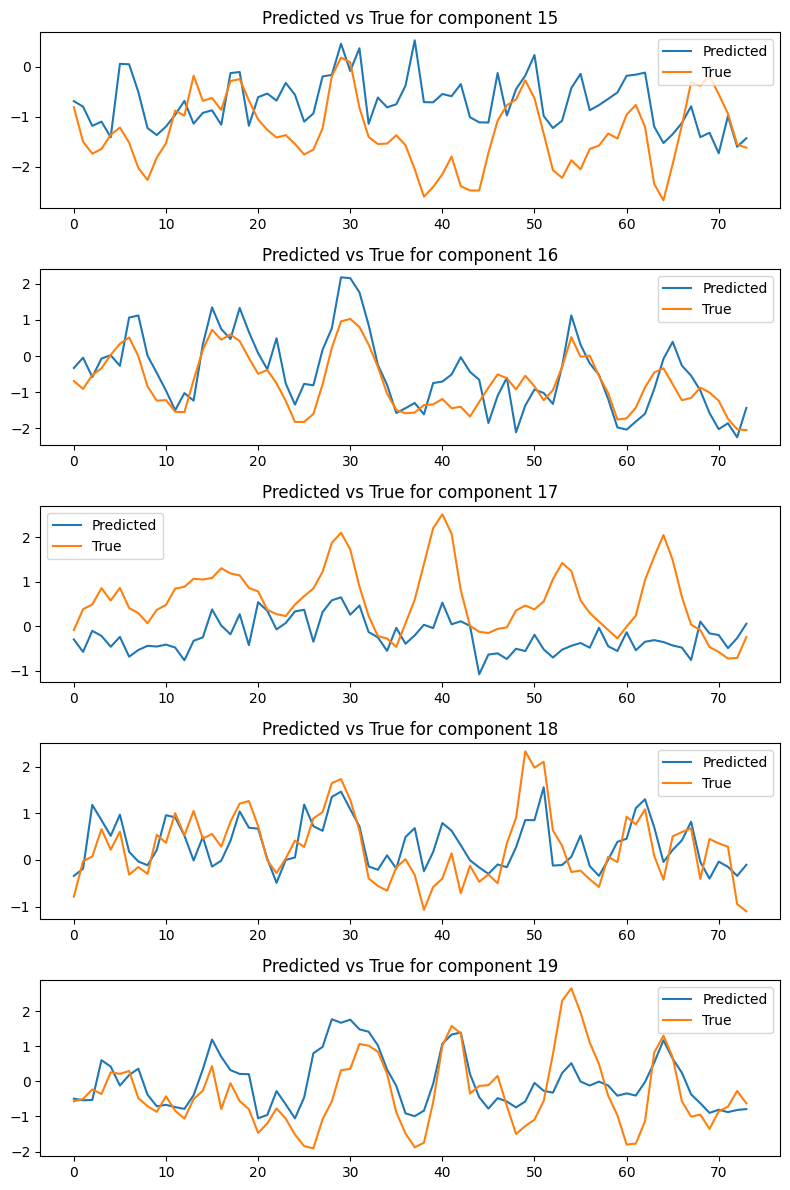

----------------------------------------------------------------------------------------------------

RESULTS FOR SELECTED_PCMCI DATA
----------------------------------------------------------------------------------------------------

Results for 15:
(74, 12, 22) (74, 1)
3/3 [==============================] - 0s 8ms/step
Correlation for true component 15:  0.1821937862045153
R2 for component 15 -0.46413816668552843
--------------------------------------------------
Results for 16:
(74, 12, 20) (74, 1)
3/3 [==============================] - 0s 7ms/step
Correlation for true component 16:  0.6458285545147616
R2 for component 16 0.18066307900837286
--------------------------------------------------
Results for 17:
(74, 12, 11) (74, 1)
3/3 [==============================] - 0s 7ms/step
Correlation for true component 17:  0.5015506410550681
R2 for component 17 -0.12135780353198355
--------------------------------------------------
Results for 18:
(74, 12, 9) (74, 1)
3/3 [===================

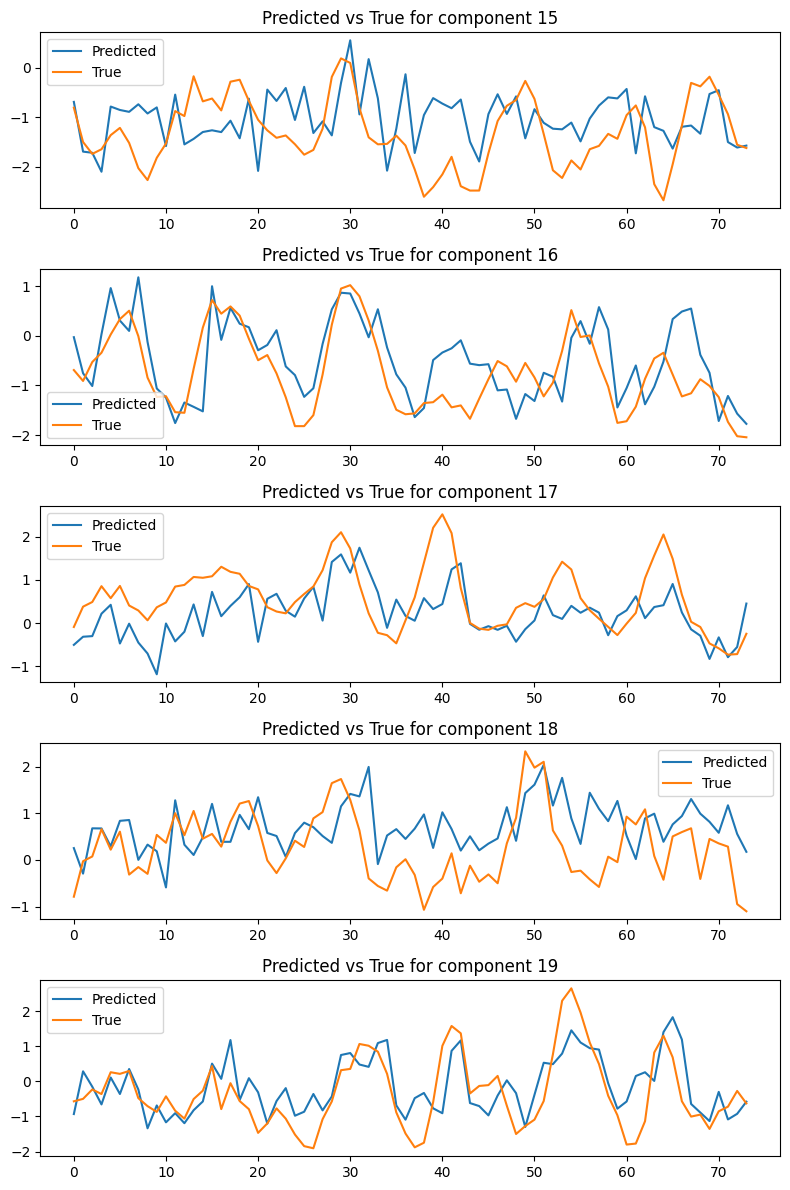

----------------------------------------------------------------------------------------------------

RESULTS FOR SELECTED_PCMCI_+AUTOREG DATA
----------------------------------------------------------------------------------------------------

Results for 15:
(74, 12, 26) (74, 1)
3/3 [==============================] - 0s 6ms/step
Correlation for true component 15:  0.4998551342888652
R2 for component 15 -0.1228610594139119
--------------------------------------------------
Results for 16:
(74, 12, 24) (74, 1)
3/3 [==============================] - 0s 7ms/step
Correlation for true component 16:  0.6901717458242234
R2 for component 16 0.42803018645280844
--------------------------------------------------
Results for 17:
(74, 12, 15) (74, 1)
3/3 [==============================] - 0s 7ms/step
Correlation for true component 17:  0.5072482548630599
R2 for component 17 0.22750751223494392
--------------------------------------------------
Results for 18:
(74, 12, 13) (74, 1)
3/3 [===========

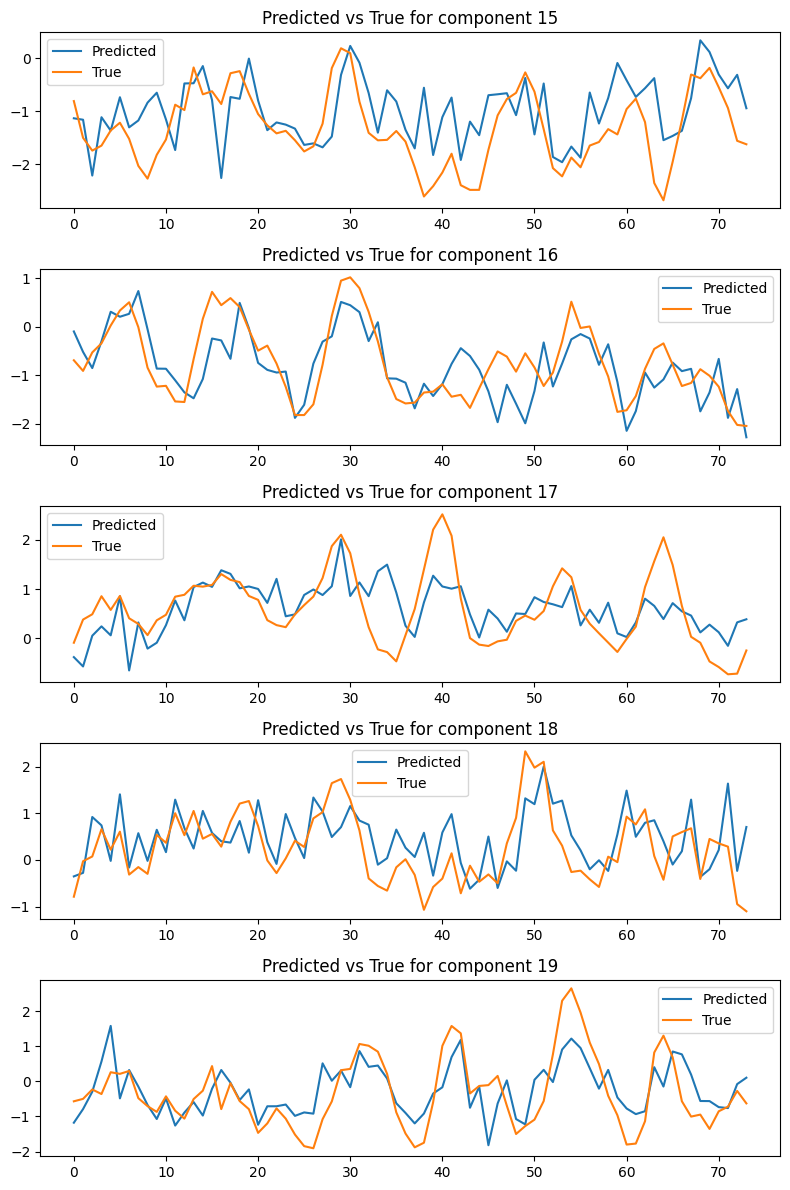

----------------------------------------------------------------------------------------------------

RESULTS FOR SELECTED_LASSO DATA
----------------------------------------------------------------------------------------------------

Results for 15:
(74, 12, 89) (74, 1)
3/3 [==============================] - 0s 10ms/step
Correlation for true component 15:  0.6079929815679032
R2 for component 15 -0.20025541902770816
--------------------------------------------------
Results for 16:
(74, 12, 78) (74, 1)
3/3 [==============================] - 0s 7ms/step
Correlation for true component 16:  0.8323988560508768
R2 for component 16 0.5483529827275384
--------------------------------------------------
Results for 17:
(74, 12, 89) (74, 1)
3/3 [==============================] - 0s 7ms/step
Correlation for true component 17:  0.6095114863782746
R2 for component 17 -1.3931569103916344
--------------------------------------------------
Results for 18:
(74, 12, 73) (74, 1)
3/3 [===================

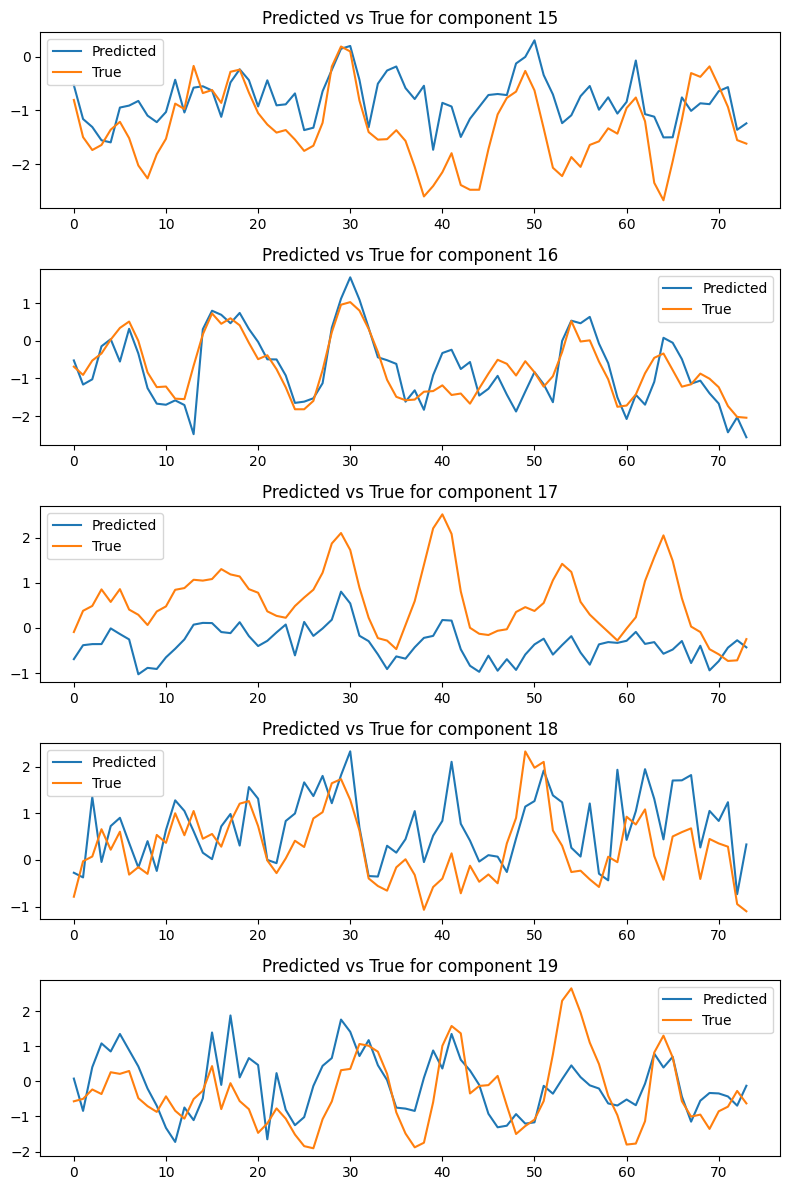

----------------------------------------------------------------------------------------------------



In [170]:
from sklearn.metrics import r2_score

# Predictions for combined data
models_dict_list = [model_components_dict_combined, model_components_dict_pcmci, model_components_dict_pcmci_auto, model_components_dict_lasso]
data_configs = ['combined', 'selected_pcmci', 'selected_pcmci_+autoreg', 'selected_lasso']
predictions_dict = {}

for config, model_dict in zip(data_configs, models_dict_list):
    print(f'RESULTS FOR {config.upper()} DATA')
    print('-' * 100)
    print()

    # fig, ax = plt.subplots(figsize=(15, n_comps[target.split('_')[0]]*2), nrows=n_comps[target.split('_')[0]]//2, ncols=3)
    fig, ax = plt.subplots(figsize=(8, 12), nrows=5, ncols=1)
    ax = ax.flatten()

    predictions_dict[config] = {}
    predictions_dict[config]['preds'] = []
    predictions_dict[config]['y_tests'] = []
    predictions_dict[config]['y_tests2'] = []

    for i, comp in enumerate(range(COMP_START, COMP_END)):
        print(f'Results for {comp}:')
        
        # X, y, X_test, y_test, scaler_X, scaler_y = load_and_prepare_data('combined', comp, 'standard')
        X_test, y_test, y_test2, scaler_y = model_dict[comp]['X_test'], model_dict[comp]['y_test'], model_dict[comp]['y_test2'], model_dict[comp]['scaler_y']

        X_final_test_seq, y_final_test_seq = create_sequences(X_test, y_test, sequence_length)
        _, y_final_test_seq2 = create_sequences(X_test, y_test2, sequence_length)
        print(X_final_test_seq.shape, y_final_test_seq.shape)

        y_pred_scaled = model_dict[comp]['model'].predict(X_final_test_seq)

        ax[i].plot(y_pred_scaled, label='Predicted')
        ax[i].plot(y_final_test_seq, label='True')
        ax[i].set_title(f'Predicted vs True for component {comp}')
        ax[i].legend()

        corr = np.corrcoef(y_final_test_seq.reshape(-1), y_pred_scaled.reshape(-1))[0, 1]
        print(f'Correlation for true component {comp}: ', corr)

        # calculate R^2
        r2 = r2_score(y_final_test_seq, y_pred_scaled)
        print(f'R2 for component {comp}', r2)
        print('-'*50)

        predictions_dict[config]['preds'].append(y_pred_scaled.reshape(-1))
        predictions_dict[config]['y_tests'].append(y_final_test_seq.reshape(-1))
        predictions_dict[config]['y_tests2'].append(y_final_test_seq2.reshape(-1))

    plt.tight_layout()
    plt.show()
    print('-' * 100)
    print()

#### Graph for predictions

In [220]:
def get_predicted_loadings(predicted_components, varimax_weights) -> np.ndarray:
    """ Get the predicted loadings from the predicted components and the varimax weights. 
        This is done to recover the predicted climate Field from the predicted components.
        Make sure the predicted components are in the right shape: (n_samples, n_components) 
        and the varimax weights are in the right shape (n_components, n_features)."""
    assert predicted_components.shape[1] == varimax_weights.shape[1], \
        "The number of components in the predicted components and the number of components in the varimax weights do not match."
    tranposed_weights = np.transpose(varimax_weights)
    return np.dot(predicted_components, tranposed_weights)

# verbosity = 0
# period_length = 38 * 2
# # time_bin_length = 3 # used for daily data

# seasons_mask = {'DJF': [12, 1, 2], 'MAM': [3, 4, 5], 'JJA': [6, 7, 8], 'SON': [9, 10, 11]}     
seasons_mask = {'FMA': [2, 3, 4], 'MJJ': [5, 6, 7], 'ASO': [8, 9, 10], 'NDJ': [11, 12, 1]} # descarted 
              
variables = [
    'sst', 
    # 'mtpr', 
    'prate',
    # 'msl'
    ]

model_name = {
    'sst': 'FULL_ERA5_SST_1940-2024_converted_detrend.nc',
    # 'mtpr': 'ERA5_mean_precipitation_1940-2024_converted_detrend.nc',
    'prate': 'PRATE_NCEP_NCAR_Reanalysis_1948-2024.nc',
    # 'msl': 'ERA5_mean_SLP_1940-2024_converted_detrend.nc'
    }

              
data_dict = {}
for var, months in itertools.product(variables, seasons_mask):
    # print(model_name[var], seasons_mask[months])
    
    # create file name, load data and save it to a dictionary
    file_name = './runs/train/train_varimax_%s_3dm_comps-%d_months-%s.bin' % (model_name[var], n_comps[var], seasons_mask[months]) # (model_name[0], n_comps, months)
    datadict = pickle.load(open(file_name, 'rb'))

    data_dict[f'{var}_{months}'] = {'results': datadict['results'], 
                                    'time_mask': datadict['results']['time_mask'], 
                                    'dateseries': datadict['results']['time'][:]}
    

d = data_dict[target]['results']
lons = d['lons']
lats = d['lats']
dateseries = data_dict[target]['dateseries']

varimax_weights = data_dict[target]['results']['weights']
loadings = d['weights'].reshape((len(lats), len(lons), d['max_comps'])) # Climate modes

# Recovering the prediction field for all the models
for config in predictions_dict.keys():
    print('-' * 100)
    print(f'Prediction Fields for {config} data')

    predictions_dict[config]['predicted_components'] = np.array(predictions_dict[config]['preds']).T
    predictions_dict[config]['true_components'] = np.array(predictions_dict[config]['y_tests']).T
    predictions_dict[config]['true_components2'] = np.array(predictions_dict[config]['y_tests2']).T

    print('varimax shape:', varimax_weights.shape, 
          'predicted components shape:', predictions_dict[config]['predicted_components'].shape, 
          'true components shape:', predictions_dict[config]['true_components'].shape)
    
    for i in range(5):
        predictions_dict[config][i] = {}
        predictions_dict[config][i]['predicted_components'] = predictions_dict[config]['predicted_components'][:,i].reshape(-1, 1)
        predictions_dict[config][i]['true_components'] = predictions_dict[config]['true_components'][:,i].reshape(-1, 1)
        predictions_dict[config][i]['true_components2'] = predictions_dict[config]['true_components2'][:,i].reshape(-1, 1)

    predictions_dict[config]['pred_field'] = get_predicted_loadings(predictions_dict[config]['predicted_components'], varimax_weights)
    predictions_dict[config]['true_field'] = get_predicted_loadings(predictions_dict[config]['true_components'], varimax_weights)
    predictions_dict[config]['true_field2'] = get_predicted_loadings(predictions_dict[config]['true_components2'], varimax_weights)

    print('pred field:', predictions_dict[config]['pred_field'].shape, 
          'true field:', predictions_dict[config]['true_field'].shape, 
          'true field 2:', predictions_dict[config]['true_field2'].shape)
    
    predictions_dict[config]['r2_score'] = r2_score(predictions_dict[config]['true_field'].flatten(), predictions_dict[config]['pred_field'].flatten())

    print(f'R2 Score (true vs pred fields):, {predictions_dict[config]["r2_score"]:.4f}')


    for i in range(5):
        predictions_dict[config][i]['pred_field'] = get_predicted_loadings(predictions_dict[config][i]['predicted_components'], varimax_weights[:,0].reshape(-1, 1))
        predictions_dict[config][i]['true_field'] = get_predicted_loadings(predictions_dict[config][i]['true_components'], varimax_weights[:,0].reshape(-1, 1))
        predictions_dict[config][i]['true_field2']= get_predicted_loadings(predictions_dict[config][i]['true_components2'], varimax_weights[:,0].reshape(-1, 1))
        
        predictions_dict[config][i]['r2_score'] = r2_score(predictions_dict[config][i]['true_field'].flatten(), predictions_dict[config][i]['pred_field'].flatten())
        print(f'R2 Score for {i} comp (true vs pred fields):, {predictions_dict[config][i]["r2_score"]:.4f}')

    
    print('-' * 100)
    print()

# Save the predictions_dict
file_name = f'./runs/encoder_results/result_dict_{model}_total-comps-{total_comps}_comp-{"-".join(matching_comp_MA)}_MA-{MA}_{"-".join(data_configs)}.pkl'
file = open(file_name, 'wb')
pickle.dump(predictions_dict, file, protocol=-1)

----------------------------------------------------------------------------------------------------
Prediction Fields for combined data
varimax shape: (96, 5) predicted components shape: (74, 5) true components shape: (74, 5)
pred field: (74, 96) true field: (74, 96) true field 2: (74, 96)
R2 Score (true vs pred fields):, 0.3171
R2 Score for 0 comp (true vs pred fields):, 0.4634
R2 Score for 1 comp (true vs pred fields):, 0.5750
R2 Score for 2 comp (true vs pred fields):, -0.4482
R2 Score for 3 comp (true vs pred fields):, 0.4965
R2 Score for 4 comp (true vs pred fields):, 0.2485
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Prediction Fields for selected_pcmci data
varimax shape: (96, 5) predicted components shape: (74, 5) true components shape: (74, 5)
pred field: (74, 96) true field: (74, 96) true field 2: (74, 96)
R2 Score (tr

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
R2 score for the season FMA of 2018 (PCMCI): 0.5360
R2 score for the season FMA of 2018 (PCMCI+AR): 0.7729
R2 score for the season FMA of 2018 (Combined): 0.1987
R2 score for the season FMA of 2018 (Lasso): -0.1577


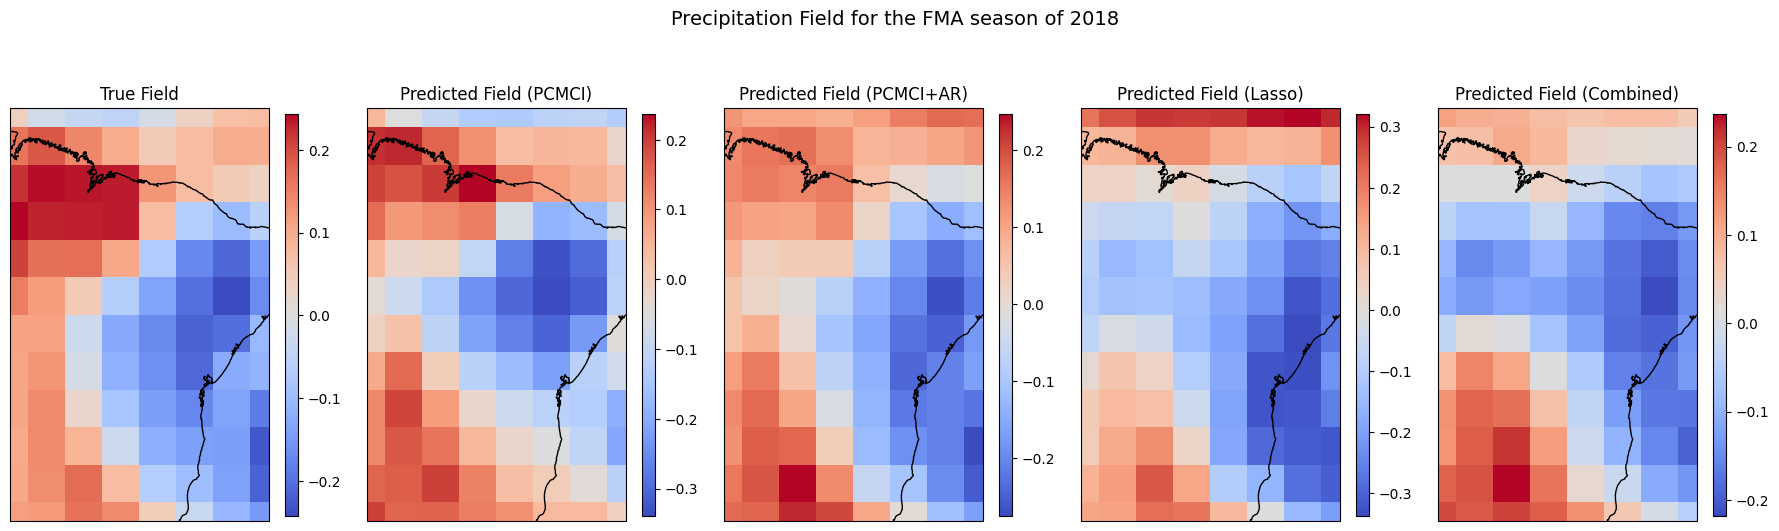

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
R2 score for the season FMA of 2019 (PCMCI): -0.3299
R2 score for the season FMA of 2019 (PCMCI+AR): -0.4506
R2 score for the season FMA of 2019 (Combined): -0.6847
R2 score for the season FMA of 2019 (Lasso): -1.0348


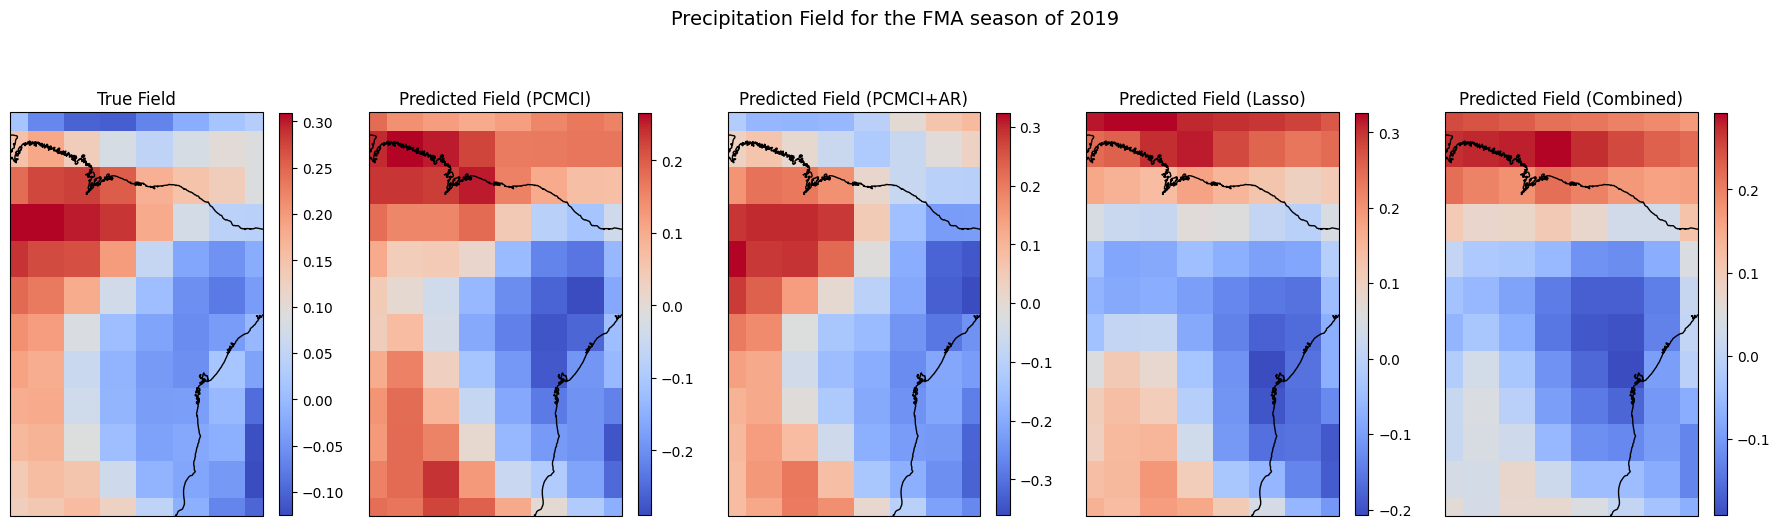

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
R2 score for the season FMA of 2020 (PCMCI): 0.1725
R2 score for the season FMA of 2020 (PCMCI+AR): 0.0563
R2 score for the season FMA of 2020 (Combined): -0.1023
R2 score for the season FMA of 2020 (Lasso): -0.1873


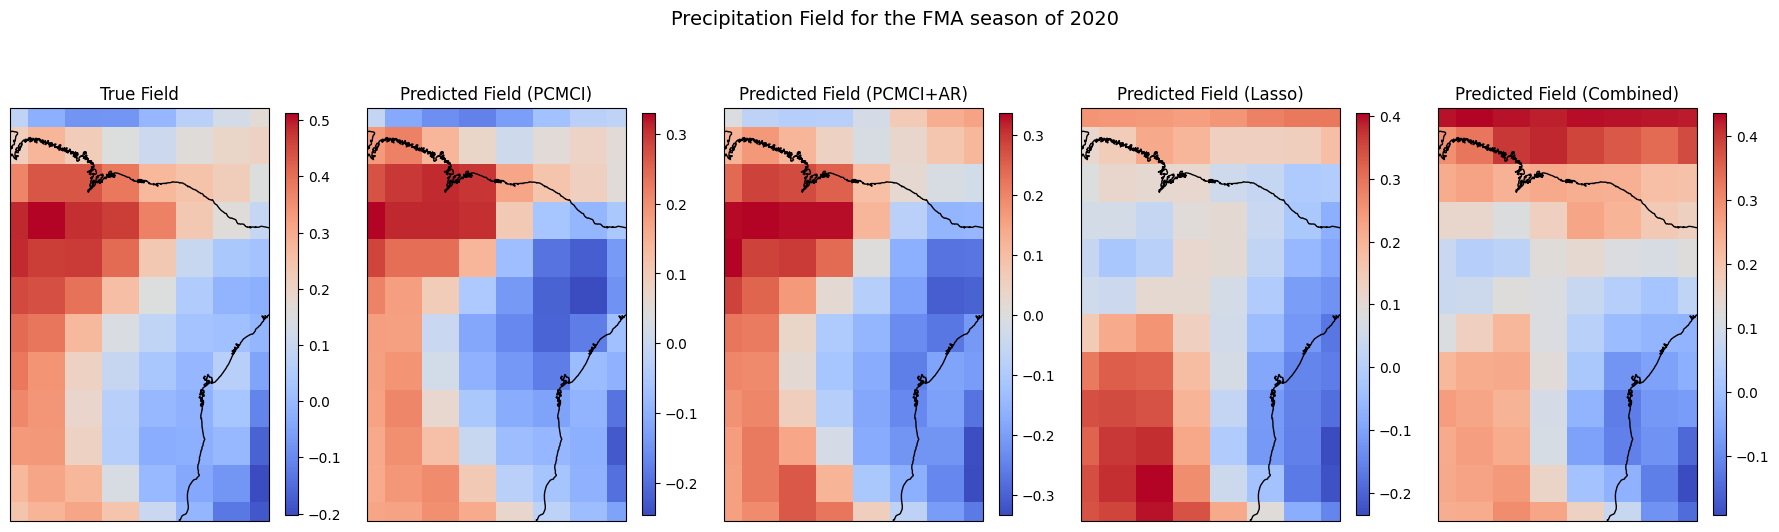

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
R2 score for the season FMA of 2021 (PCMCI): 0.3563
R2 score for the season FMA of 2021 (PCMCI+AR): 0.7380
R2 score for the season FMA of 2021 (Combined): 0.4789
R2 score for the season FMA of 2021 (Lasso): 0.3761


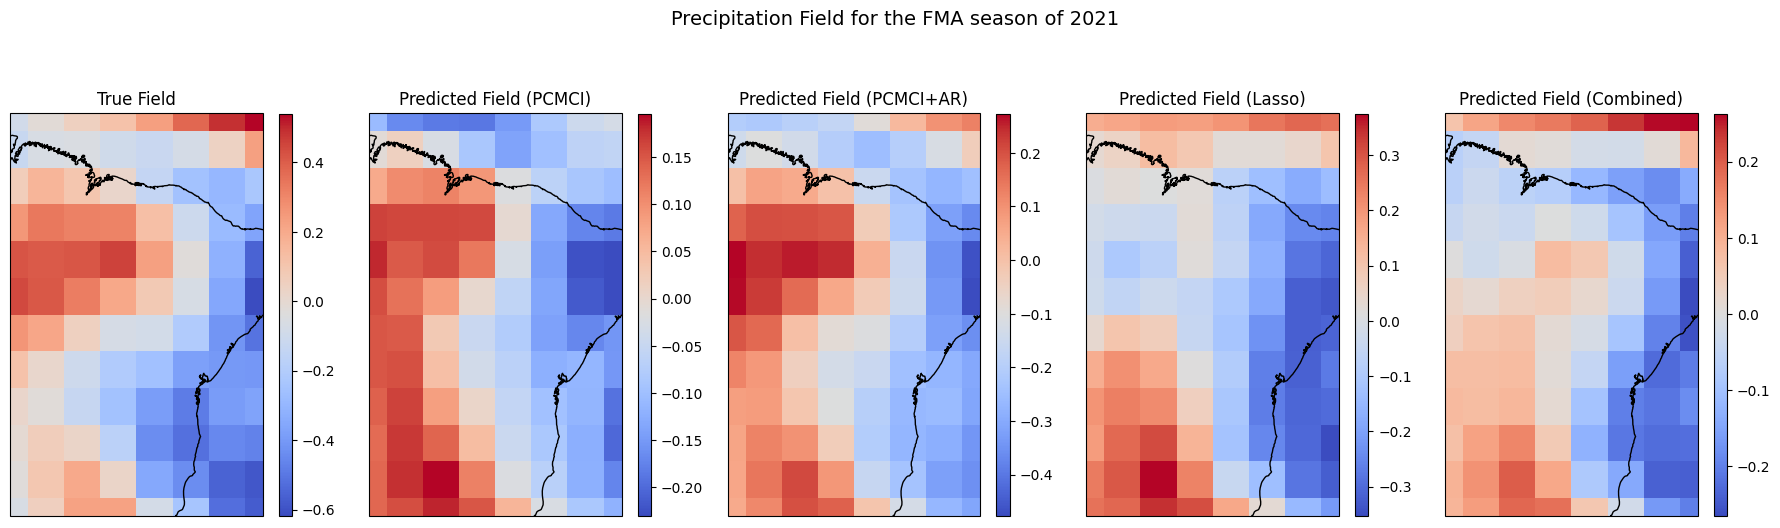

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
R2 score for the season FMA of 2022 (PCMCI): 0.3482
R2 score for the season FMA of 2022 (PCMCI+AR): 0.4670
R2 score for the season FMA of 2022 (Combined): -0.0022
R2 score for the season FMA of 2022 (Lasso): -0.2054


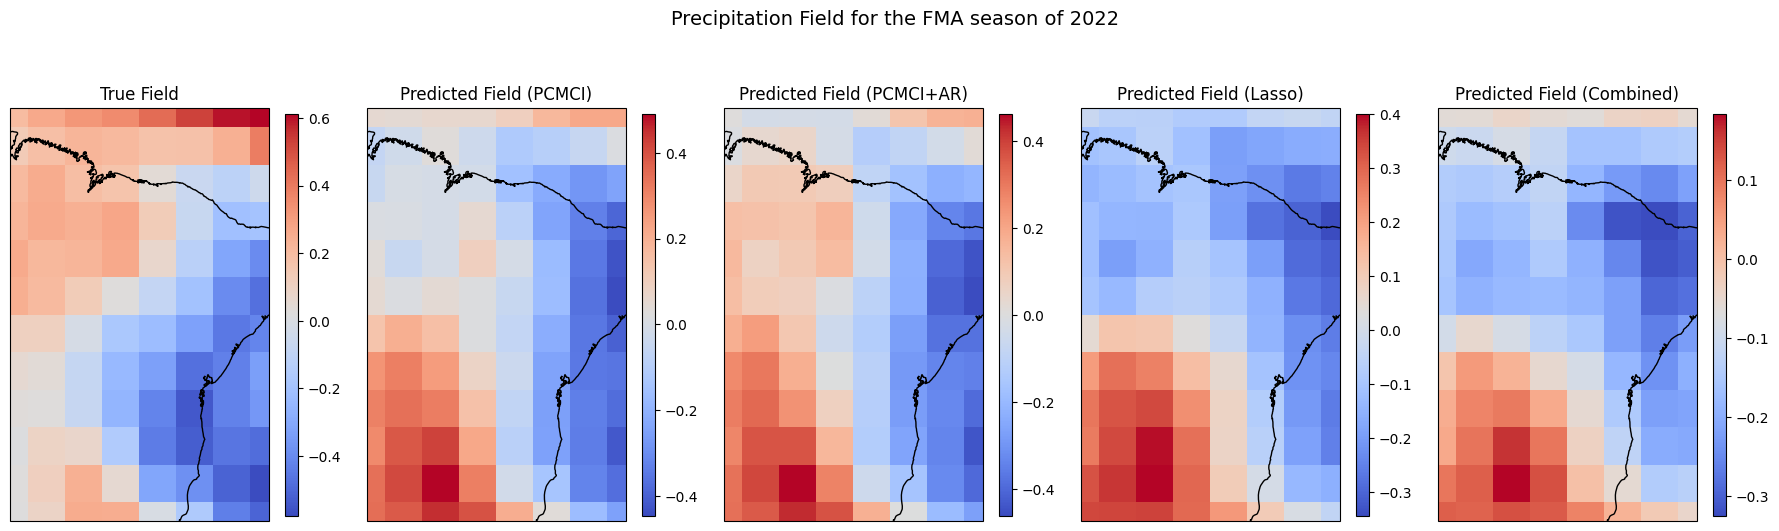

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
R2 score for the season FMA of 2023 (PCMCI): 0.7693
R2 score for the season FMA of 2023 (PCMCI+AR): 0.8058
R2 score for the season FMA of 2023 (Combined): 0.3245
R2 score for the season FMA of 2023 (Lasso): 0.1771


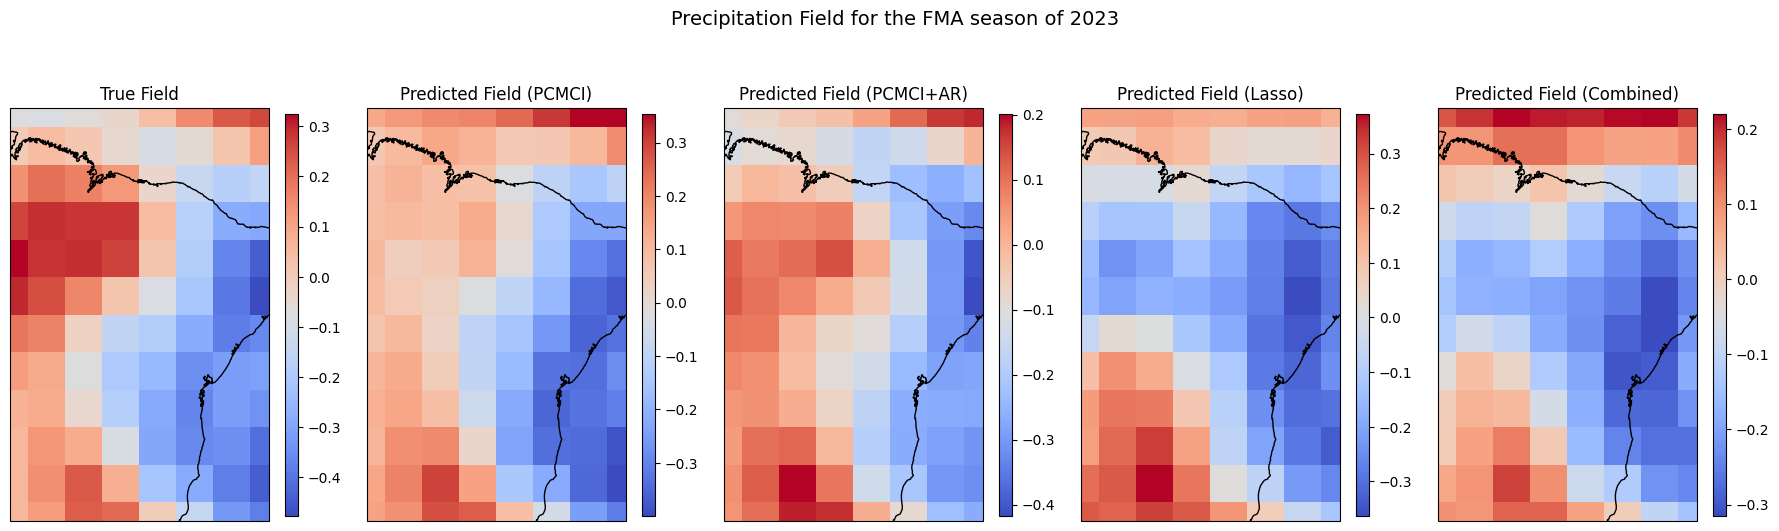

In [198]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# for config in predictions_dict.keys():
#     pred_field = predictions_dict[config]['pred_field']
#     true_field = predictions_dict[config]['true_field2']

pred_field = predictions_dict['selected_pcmci_+autoreg']['pred_field']
pred_field_p = predictions_dict['selected_pcmci']['pred_field']
pred_field_c = predictions_dict['combined']['pred_field']
pred_field_l = predictions_dict['selected_lasso']['pred_field']
true_field = predictions_dict['selected_pcmci_+autoreg']['true_field2']

pred_field_DJR_mean = []
pred_field_DJR_mean_p = []
pred_field_DJR_mean_c = []
pred_field_DJR_mean_l = []
true_field_DJR_mean = []

# For each year from 2017 to 2023
for i in range(6):
    print('-' * 185)
    aug = 12 * i 

    # Calculate average for the season DJF. The first data point in the test data is november 2017
    # Hence the mean is calculated from the second data point to the fourth data point
    pred_field_DJF = np.mean(pred_field[(3+aug):(6+aug),:], axis=0)
    pred_field_DJF_p = np.mean(pred_field_p[(3+aug):(6+aug),:], axis=0)
    pred_field_DJF_c = np.mean(pred_field_c[(3+aug):(6+aug),:], axis=0)
    pred_field_DJF_l = np.mean(pred_field_l[(3+aug):(6+aug),:], axis=0)
    true_field_DJF = np.mean(true_field[(3+aug):(6+aug)], axis=0)

    pred_field_DJR_mean.append(pred_field_DJF)
    pred_field_DJR_mean_p.append(pred_field_DJF_p)
    pred_field_DJR_mean_c.append(pred_field_DJF_c)
    pred_field_DJR_mean_l.append(pred_field_DJF_l)
    true_field_DJR_mean.append(true_field_DJF)

    # Print and calculate the R2 score for the season DJF
    r2score = r2_score(true_field_DJF.flatten(), pred_field_DJF.flatten())
    r2score_p = r2_score(true_field_DJF.flatten(), pred_field_DJF_p.flatten())
    r2score_c = r2_score(true_field_DJF.flatten(), pred_field_DJF_c.flatten())
    r2score_l = r2_score(true_field_DJF.flatten(), pred_field_DJF_l.flatten())
    
    print(f'R2 score for the season FMA of {str(2018 + i)} (PCMCI): {r2score_p:.4f}')
    print(f'R2 score for the season FMA of {str(2018 + i)} (PCMCI+AR): {r2score:.4f}')
    print(f'R2 score for the season FMA of {str(2018 + i)} (Combined): {r2score_c:.4f}')
    print(f'R2 score for the season FMA of {str(2018 + i)} (Lasso): {r2score_l:.4f}')

    # Reshape the predicted loadings to a (n_lat, n_lon) grid
    pred_grid = pred_field_DJF.reshape(len(lats), len(lons))
    pred_grid_p = pred_field_DJF_p.reshape(len(lats), len(lons))
    pred_grid_c = pred_field_DJF_c.reshape(len(lats), len(lons))
    pred_grid_l = pred_field_DJF_l.reshape(len(lats), len(lons))
    true_grid = true_field_DJF.reshape(len(lats), len(lons))

    # Figure with 3 subplots side by side
    fig, axs = plt.subplots(1, 5, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

    # Plotting the True Field
    ax = axs[0]
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    mesh = ax.pcolormesh(lons, lats, true_grid, transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
    ax.set_title('True Field')

    # Plotting the Predicted Field for PCMCI+AR
    ax = axs[1]
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    mesh = ax.pcolormesh(lons, lats, pred_grid_p, transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
    ax.set_title('Predicted Field (PCMCI)')

    # Plotting the Predicted Field for PCMCI+AR
    ax = axs[2]
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    mesh = ax.pcolormesh(lons, lats, pred_grid, transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
    ax.set_title('Predicted Field (PCMCI+AR)')

    # Plotting the Predicted Field for the Lasso data as benchmark 
    ax = axs[3]
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    mesh = ax.pcolormesh(lons, lats, pred_grid_l, transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
    ax.set_title('Predicted Field (Lasso)')

    # Plotting the Predicted Field for the combined data as benchmark 
    ax = axs[4]
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    mesh = ax.pcolormesh(lons, lats, pred_grid_c, transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
    ax.set_title('Predicted Field (Combined)')

    # Title for the whole figure
    fig.suptitle(f"Precipitation Field for the FMA season of {2018 + i}", fontsize=14)
    plt.tight_layout()
    plt.show()
    # print('-' * 150)


INFO:root:funciona


Loading data:
	Original date range 1948-01-01 00:00:00 - 2024-06-01 00:00:00 
Original data shape (918, 94, 192)
	Slicing lon = [310, 325], lat = [-20, 1]
	anomalize means_variance with base period (1948, 2022)
Stard and end dates:  1948-01-01 00:00:00 2024-06-01 00:00:00
	Slicing from = 1948-01-01 00:00:00 to 2024-01-01 00:00:00
Stard and end dates after slicing:  1948-01-01 00:00:00 2023-12-01 00:00:00
2016 DJF season index: 826


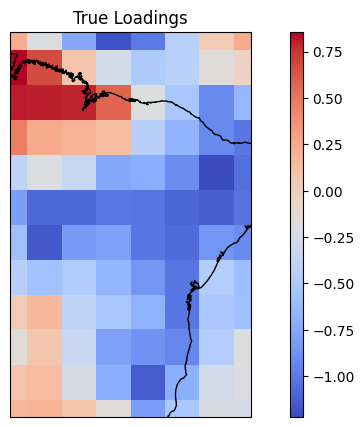

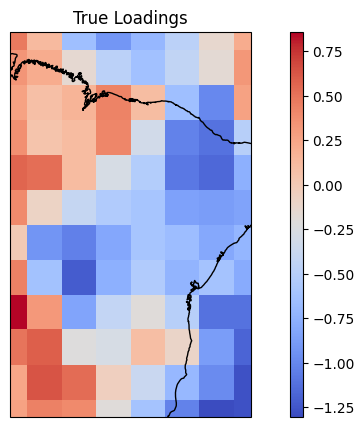

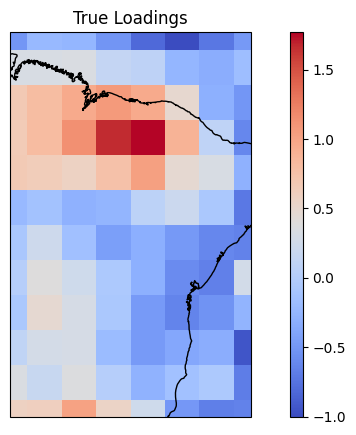

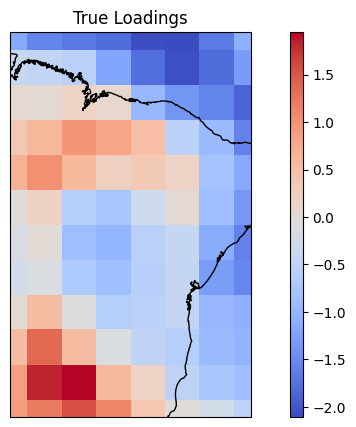

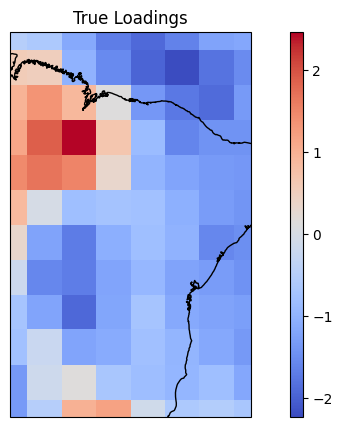

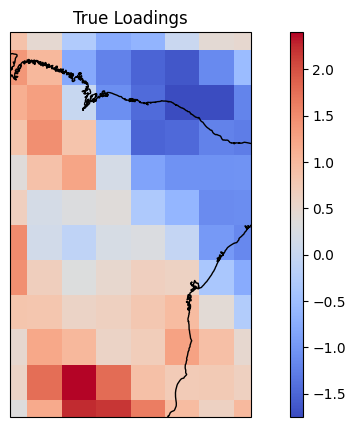

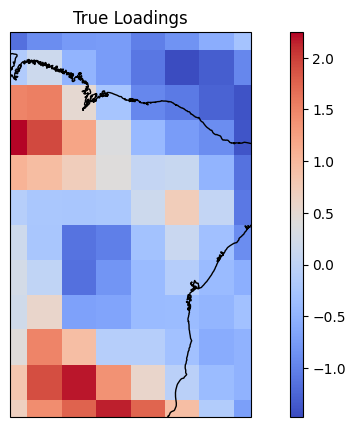

In [97]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from utils_pca_fun import *
from geo_field_jakob import GeoField

d = {}

d['data_parameters'] = {
    'folder_name' : './data/',
    'load_filename' :  'PRATE_NCEP_NCAR_Reanalysis_1948-2024.nc', 
    'varname' : 'prate',
                
    'use_cdftime' : True,
    'from_date' : datetime(1948, 1, 1),
    'to_date' : datetime(2024, 1, 1), 
    'anomalize': 'means_variance',
    'anomalize_base' :  (1948, 2022),
    'slice_lat' : [-20, 1],
    'slice_lon' : [310, 325],
    'level' : None,   
    'verbosity' : 2,
    }

geo_object = load_data(**d['data_parameters'])
data = geo_object.data()
start_end_date = [geo_object.start_date, geo_object.end_date]
daterange = pd.date_range(start_end_date[0], start_end_date[1], freq='M')

lats, lons = geo_object.lats, geo_object.lons

idx = daterange.get_loc('2016-11-30')
print('2016 DJF season index:', idx)
for i in range(7):
    aug = 12 * i 
    prep = data[(idx+aug):(idx+3+aug), :, :]
    # Reshape the predicted loadings to a (n_lat, n_lon) grid
    true_loadings_grid = np.mean(prep, axis=0)

    # Plotting the map
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())


    # Plot the data on the map
    mesh = ax.pcolormesh(lons, lats, true_loadings_grid, transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

    # Add a colorbar
    plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, aspect=30)

    plt.title('True Loadings')
    plt.show()

#### Forecast assesment and measures

In [119]:
from scipy.stats import shapiro, normaltest

# Apply Shapiro-Wilk test for each spatial point across the 7 years
sw_pvals, normal_pvals = [], []
for i in range(true_field.shape[1]):
    stat, p = shapiro(true_field[:, i])
    sw_pvals.append(p)

    stat, p = normaltest(true_field[:, i])
    normal_pvals.append(p)
    
# Interpret the results: if p > 0.05, data is considered normal at the 5% significance level
print(sum([val > 0.05 for val in sw_pvals]))
print(sum([val > 0.05 for val in normal_pvals]))

54
72


(12, 8)


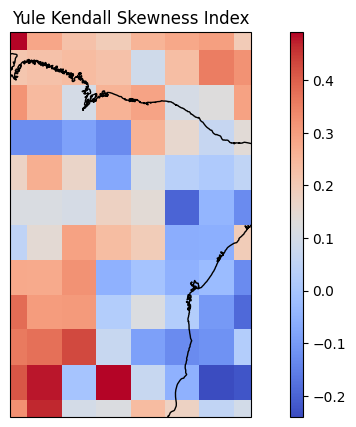

In [120]:
import matplotlib.pyplot as plt
import scipy.stats as stats


def yule_kendall_skewness(data):

    Q1 = np.percentile(data, 25, axis=0)
    Q2 = np.percentile(data, 50, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    
    yk_skewness = ((Q3 - Q2) - (Q2 - Q1)) / (Q3 - Q1)
    
    return yk_skewness

yks = []
for i in range(true_field.shape[1]):
    yks.append(yule_kendall_skewness(true_field[:, i]))

yks = np.array(yks).reshape(len(lats), len(lons))
print(yks.shape)

fig, axs = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

# Plotting the yule kendall skewness values
axs.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
mesh = axs.pcolormesh(lons, lats, yks, transform=ccrs.PlateCarree(), cmap='coolwarm')
axs.coastlines()
axs.add_feature(cfeature.BORDERS)
plt.colorbar(mesh, ax=axs, orientation='vertical', pad=0.05, aspect=30)
axs.set_title('Yule Kendall Skewness Index')
plt.show()

In [123]:
from scipy.stats import pearsonr

pred_field_DJR_mean = np.stack(pred_field_DJR_mean, axis=0)
pred_field_DJR_mean_c = np.stack(pred_field_DJR_mean_c, axis=0)
pred_field_DJR_mean_l = np.stack(pred_field_DJR_mean_l, axis=0)
true_field_DJR_mean = np.stack(true_field_DJR_mean, axis=0)

THRESHOLD = 0.66

# Since the components are already anomalized, can calculate the correlation directly
acc, _ = pearsonr(pred_field_DJR_mean.flatten(), true_field_DJR_mean.flatten())
acc_combined, _ = pearsonr(pred_field_DJR_mean_c.flatten(), true_field_DJR_mean.flatten())
acc_lasso, _ = pearsonr(pred_field_DJR_mean_l.flatten(), true_field_DJR_mean.flatten())

print(f'Anomaly Correlation Coefficient for pcmci + AR: {acc:.4f}')
print(f'Anomaly Correlation Coefficient for combined data: {acc_combined:.4f}')
print(f'Anomaly Correlation Coefficient for lasso selection: {acc_lasso:.4f}')

Anomaly Correlation Coefficient for pcmci + AR: 0.7821
Anomaly Correlation Coefficient for combined data: 0.4934
Anomaly Correlation Coefficient for lasso selection: 0.5126


In [125]:
from sklearn.linear_model import LogisticRegression

def logistic_brier_score(forecast, observation, threshold) -> float:
    """ 
    Calculate the Brier Score for the predicted field using a logistic regression model.
    The logistic regression model is used to predict the probability of the observed outcome being above a certain threshold.

    Parameters:
    forecast (np.ndarray): The predicted field
    observation (np.ndarray): The true field
    threshold (float): The threshold value to use for the binary labels        
    """
    
    pred_field_flat = forecast.flatten()
    threshold_values = np.percentile(observation, threshold * 100, axis=0)

    # Create binary labels to use as target on the logit based on the threshold values
    binary_labels = (observation >= threshold_values).astype(int).flatten()

    # Logit model using predicted field as features and binary labels as targets
    logistic_model = LogisticRegression()
    logistic_model.fit(pred_field_flat.reshape(-1, 1), binary_labels)

    # Logit probabilities
    predicted_probabilities = logistic_model.predict_proba(pred_field_flat.reshape(-1, 1))[:, 1]

    # Observed outcomes binary
    observed_outcomes = (observation >= threshold_values).astype(int).flatten()

    brier_scores = (predicted_probabilities - observed_outcomes) ** 2
    return brier_scores 

brier_scores = logistic_brier_score(pred_field_DJR_mean, true_field_DJR_mean, THRESHOLD)
mean_brier_score = np.mean(brier_scores)

brier_scores_combined = logistic_brier_score(pred_field_DJR_mean_c, true_field_DJR_mean, THRESHOLD)
mean_brier_score_combined = np.mean(brier_scores_combined)

brier_scores_lasso = logistic_brier_score(pred_field_DJR_mean_l, true_field_DJR_mean, THRESHOLD)
mean_brier_score_lasso = np.mean(brier_scores_lasso)

print(f"Brier Score with Logistic Regression for pcmci + AR data: {mean_brier_score:.4f}")
print(f"Brier Score with Logistic Regression for combined data: {mean_brier_score_combined:.4f}")
print(f"Brier Score with Logistic Regression for combined data: {mean_brier_score_lasso:.4f}")

Brier Score with Logistic Regression for pcmci + AR data: 0.2186
Brier Score with Logistic Regression for combined data: 0.2098
Brier Score with Logistic Regression for combined data: 0.2170


In [126]:
def calculate_Brier_Score(true_field, pred_field, threshold) -> float:
    """ Calculate the Brier Score for the predicted field. """

    # Calculate the treshold value for each grid point. (each grid point is a time series and we calculate the threshold for each time series)
    threshold_values = np.percentile(true_field, threshold * 100, axis=0)

    # For each grid point and time step, check if the observed outcome is above the threshold (precipitation above the threshold)
    observed_outcomes = (true_field >= threshold_values).astype(int)
    predicted_outcomes = (pred_field >= threshold_values).astype(int)

    # Compute the brier score for each grid point and time step
    brier_scores = (predicted_outcomes - observed_outcomes) ** 2
    mean_brier_score = np.mean(brier_scores)

    return mean_brier_score

## Calculate the Brier Score for each year from 2017 to 2023
# for i in range(7):
#     b_score = calculate_Brier_Score(true_field_DJR_mean[i], pred_field_DJR_mean[i], threshold_values)
#     print(f"Brier Score with percentiles for {2017 + i}: {b_score:.4f}")

mean_b_score = calculate_Brier_Score(true_field_DJR_mean, pred_field_DJR_mean, THRESHOLD)
mean_b_score_c = calculate_Brier_Score(true_field_DJR_mean, pred_field_DJR_mean_c, THRESHOLD)
mean_b_score_l = calculate_Brier_Score(true_field_DJR_mean, pred_field_DJR_mean_l, THRESHOLD)

print(f"Brier Score with percentiles for pcmci + AR data: {mean_b_score:.4f}")
print(f"Brier Score with percentiles for combined data: {mean_b_score_c:.4f}")
print(f"Brier Score with percentiles for Lasso: {mean_b_score_l:.4f}")

Brier Score with percentiles for pcmci + AR data: 0.3490
Brier Score with percentiles for combined data: 0.3785
Brier Score with percentiles for Lasso: 0.4149


#### Uncertainty assessment

In [103]:
models_dict_list = [model_components_dict_combined, model_components_dict_pcmci, model_components_dict_pcmci_auto, model_components_dict_lasso]
data_configs = ['combined', 'selected_pcmci', 'selected_pcmci_+autoreg', 'selected_lasso']
MC_data = {}
for config, model_dict in zip(data_configs, models_dict_list):
    MC_data[config] = {}
    for i, comp in enumerate(range(COMP_START, COMP_END)):   
        MC_data[config][comp] = {}
        X_test, y_test, y_test2, scaler_y = model_dict[comp]['X_test'], model_dict[comp]['y_test'], model_dict[comp]['y_test2'], model_dict[comp]['scaler_y']

        X_final_test_seq, y_final_test_seq = create_sequences(X_test, y_test, sequence_length)
        _, y_final_test_seq2 = create_sequences(X_test, y_test2, sequence_length)

        MC_data[config][comp]['X'] = X_final_test_seq
        MC_data[config][comp]['y'] = y_final_test_seq.reshape(-1)
        MC_data[config][comp]['y2'] = y_final_test_seq2.reshape(-1)

In [229]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Predictions for combined data
models_dict_list = [model_components_dict_combined, model_components_dict_pcmci, model_components_dict_pcmci_auto, model_components_dict_lasso]
data_configs = ['combined', 'selected_pcmci', 'selected_pcmci_+autoreg', 'selected_lasso']
MC_predictions_dict = {}

for config, model_dict in zip(data_configs, models_dict_list):
    MC_predictions_dict[config] = {}
    MC_predictions_dict[config]['ts_field_r2'] = []
    MC_predictions_dict[config]['season_field_acc'] = []
    MC_predictions_dict[config]['yearly_season_r2'] = {str(2017 + j): [] for j in range(7)}
    for comp in range(COMP_START, COMP_END):
        MC_predictions_dict[config][comp] = {'corr': [], 'r2': []}
    
    for _ in range(1000):
        data_temp = {}
        data_temp[config] = {'preds': [], 'y_tests': [], 'y_tests2':[]}

        for i, comp in enumerate(range(COMP_START, COMP_END)):   
            X_final_test_seq = MC_data[config][comp]['X']
            y_final_test_seq = MC_data[config][comp]['y']
            y_final_test_seq2 = MC_data[config][comp]['y2']

            y_pred_scaled = model_dict[comp]['model'].predict(X_final_test_seq)
            y_pred_scaled = y_pred_scaled.reshape(-1)

            corr = np.corrcoef(y_final_test_seq, y_pred_scaled)[0, 1]
            r2 = r2_score(y_final_test_seq, y_pred_scaled)

            MC_predictions_dict[config][comp]['corr'].append(corr)
            MC_predictions_dict[config][comp]['r2'].append(r2)

            data_temp[config]['preds'].append(y_pred_scaled)
            data_temp[config]['y_tests'].append(y_final_test_seq)
            data_temp[config]['y_tests2'].append(y_final_test_seq2)

        
        predicted_components = np.array(data_temp[config]['preds']).T
        true_components = np.array(data_temp[config]['y_tests']).T
        true_components2 = np.array(data_temp[config]['y_tests2']).T

        pred_field = get_predicted_loadings(predicted_components, varimax_weights)
        true_field = get_predicted_loadings(true_components, varimax_weights)
        true_field2 = get_predicted_loadings(true_components2, varimax_weights)
                
        MC_predictions_dict[config]['ts_field_r2'].append(r2_score(true_field.flatten(), pred_field.flatten()))

        pred_field_DJR_mean = []
        true_field_DJR_mean = []

        # For each year from 2018 to 2023
        for j in range(6):
            aug = 12 * j

            # Calculate average for the season DJF. The first data point in the test data is november 2017
            # Hence the mean is calculated from the second data point to the fourth data point
            pred_field_DJF = np.mean(pred_field[(3+aug):(6+aug),:], axis=0)
            true_field_DJF = np.mean(true_field2[(3+aug):(6+aug)], axis=0)

            pred_field_DJR_mean.append(pred_field_DJF)
            true_field_DJR_mean.append(true_field_DJF)

            # Print and calculate the R2 score for the season DJF
            year_r2score = r2_score(true_field_DJF.flatten(), pred_field_DJF.flatten())
            MC_predictions_dict[config]['yearly_season_r2'][str(2018 + j)].append(year_r2score)

        pred_field_DJR_mean = np.stack(pred_field_DJR_mean, axis=0)
        true_field_DJR_mean = np.stack(true_field_DJR_mean, axis=0)
        
        # Since the components are already anomalized, we can calculate the correlation directly
        acc, _ = pearsonr(pred_field_DJR_mean.flatten(), true_field_DJR_mean.flatten())

        MC_predictions_dict[config]['season_field_acc'].append(acc)

3/3 [==============================] - 0s 8ms/step


In [232]:
file_name = f'./runs/encoder_results/MC_result_dict_{model}_total-comps-{total_comps}_comp-{"-".join(matching_comp_MA)}_MA-{MA}_{"-".join(data_configs)}.pkl'
file = open(file_name, 'wb')
pickle.dump(predictions_dict, file, protocol=-1)

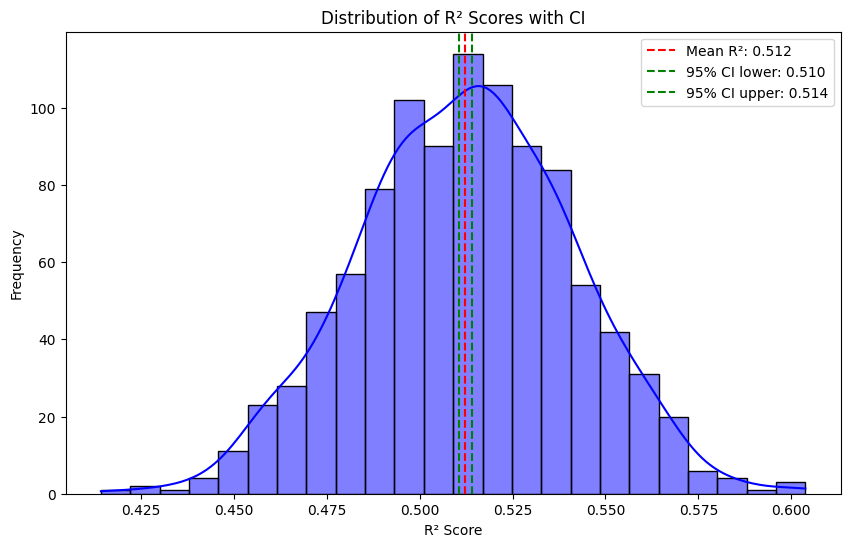

In [233]:
import seaborn as sns

# r2_scores = np.array(MC_predictions_dict['selected_pcmci_+autoreg']['season_field_acc'])
r2_scores = np.array(MC_predictions_dict['selected_lasso']['season_field_acc'])

mean_r2 = np.mean(r2_scores)
std_error = np.std(r2_scores) / np.sqrt(len(r2_scores))
confidence_interval = (mean_r2 - 1.96 * std_error, mean_r2 + 1.96 * std_error)

plt.figure(figsize=(10, 6))
sns.histplot(r2_scores, kde=True, color='blue')
plt.axvline(mean_r2, color='red', linestyle='--', label=f'Mean R²: {mean_r2:.3f}')
plt.axvline(confidence_interval[0], color='green', linestyle='--', label=f'95% CI lower: {confidence_interval[0]:.3f}')
plt.axvline(confidence_interval[1], color='green', linestyle='--', label=f'95% CI upper: {confidence_interval[1]:.3f}')
plt.title('Distribution of R2 Scores with CI')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


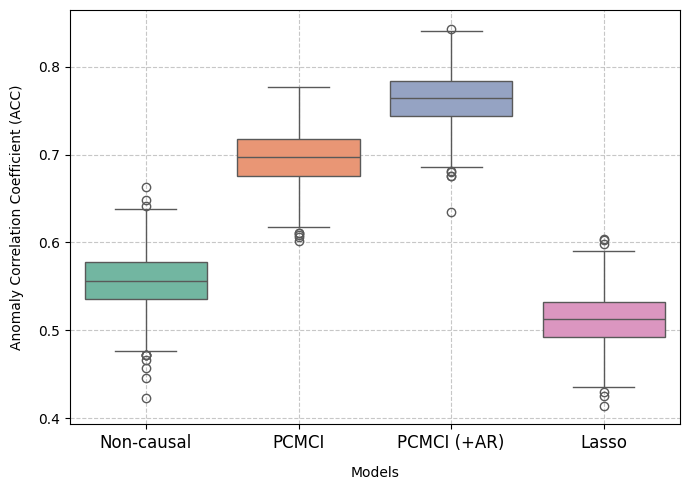

In [236]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

r2_scores_all_models = [MC_predictions_dict[config]['season_field_acc'] for config in data_configs]
# r2_scores_all_models = [MC_predictions_dict[config]['season_field_acc'] for config in data_configs]

colors = sns.color_palette("Set2", len(r2_scores_all_models))
labels = ['Non-causal', 'PCMCI', 'PCMCI (+AR)', 'Lasso']

plt.figure(figsize=(7, 5))

sns.boxplot(data=r2_scores_all_models, palette=colors)
plt.xticks(ticks=np.arange(len(data_configs)), labels=labels, fontsize=12)
plt.yticks()

# plt.title('Anomaly Correlation Coefficient (ACC) Comparison for Different Models with Monte Carlo Dropout', pad=20)
plt.ylabel('Anomaly Correlation Coefficient (ACC)', labelpad=10)
plt.xlabel('Models', labelpad=10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


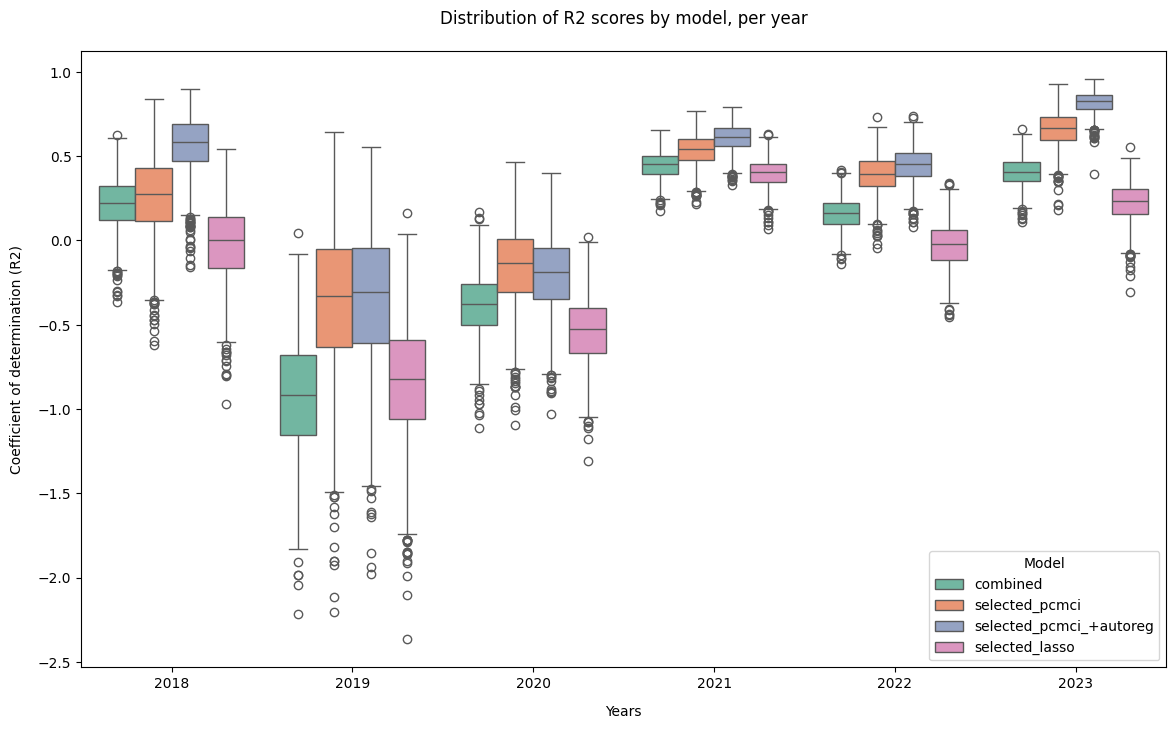

In [260]:
r2_scores_all_years = {year: [MC_predictions_dict[config]['yearly_season_r2'][str(year)] for config in data_configs] for year in range(2018, 2024)}

r2_scores_all_years = [{'year': year, 
                        'model': config,
                        'r2': r2} 
                        for year in range(2018, 2024)
                        for config in data_configs 
                        for r2 in MC_predictions_dict[config]['yearly_season_r2'][str(year)]
                        ]

# for i in range(6):
#     print(f"Year {2018 + i}")
#     print(np.mean(MC_predictions_dict['selected_pcmci_+autoreg']['yearly_season_r2'][str(2018 + i)]))
#     print(np.mean(MC_predictions_dict['selected_lasso']['yearly_season_r2'][str(2018 + i)]))
#     print()

r2_scores_all_years = pd.DataFrame(r2_scores_all_years)

plt.figure(figsize=(14, 8))
sns.boxplot(x='year', y='r2', hue='model', data=r2_scores_all_years, palette=colors)
plt.title('Distribution of R2 scores by model, per year', pad=20)
plt.legend(title='Model')
plt.ylabel('Coefficient of determination (R2)', labelpad=10)
plt.xlabel('Years', labelpad=10)
plt.show()